# Import Libraries

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [5]:
import pandas as pd
import numpy as np
import re
import gc
from datetime import datetime as dt
from datetime import timedelta, timezone
import pytz
from zoneinfo import ZoneInfo
import os, stat

os.chdir('/eos/user/m/mdtoffline/mdt_dcs_offline/streamlit/mdt-dcs-viewer')

from functions import *

import plotly.graph_objects as go
from beauty import Beauty
import libpbeastpy

pd.options.mode.chained_assignment = None  # default='warn'

In [6]:
# setup pbeast python API

from beauty import Beauty
import libpbeastpy

db = libpbeastpy.ServerProxy('http://pc-tbed-bst-prod:8080')
beauty = Beauty('http://pc-tbed-bst-prod:8080')

number_of_chambers = 1112

# General Debug (Not generally used in deployment)

In [7]:
l = 512.0

print(hex(int(l)))

0x200


In [8]:
fmt = '%Y-%m-%d %H:%M:%S'

save_path = '/eos/user/m/mdtoffline/mdt_dcs_offline/streamlit/mdt-dcs-saved-run-analysis/'

In [9]:
# For run 480407

start_dt = '2024-07-17 15:30:00.000000+0200' # from atlas-datasummary.web.cern.ch
end_dt = '2024-07-18 17:21:00.000000+0200'

fmt = '%Y-%m-%d %H:%M:%S.%f%z'

since_dt = dt.strptime(start_dt, fmt)
till_dt = dt.strptime(end_dt, fmt)
print("Query Start Time:", since_dt)
print("Query Start Time:", since_dt.astimezone(tz=timezone.utc).replace(tzinfo=None))
print("Query End Time:", till_dt, '\n')

since_ts = int((pd.to_datetime(start_dt)).timestamp()*1e6)
till_ts = int((pd.to_datetime(end_dt)).timestamp()*1e6)

print(since_ts)
print(till_ts)

Query Start Time: 2024-07-17 15:30:00+02:00
Query Start Time: 2024-07-17 13:30:00
Query End Time: 2024-07-18 17:21:00+02:00 

1721223000000000
1721316060000000


In [10]:
rn_df = beauty.timeseries(since_dt.replace(tzinfo=None), till_dt.replace(tzinfo=None), 'DCS', 'ATLAS_PVSSMDT', 'value-number', 'ATLMDTPS2:CAEN/PSMDT02/branchController00/easyCrate0/easyBoard01/channel001.actual.iMon',None, False)[0]
rn_df = pd.DataFrame({'value': rn_df.array , 'dt': rn_df.index})

rn_df['value'] = rn_df['value'].astype(float)
rn_df['ts'] = rn_df['dt'].values.astype(int) // 10**3
rn_df.sort_values(by=['ts'], inplace=True)
rn_df = rn_df[(rn_df['ts'] > since_ts) & (rn_df['ts'] < till_ts)]

rn_df

value                               dt                ts
0      0.8 2024-07-17 15:32:14.529000+02:00  1721223134529000
1      4.1 2024-07-17 15:32:16.539000+02:00  1721223136539000
2      3.7 2024-07-17 15:32:18.534000+02:00  1721223138534000
3      3.5 2024-07-17 15:32:20.544000+02:00  1721223140544000
4      2.8 2024-07-17 15:32:51.584000+02:00  1721223171584000
..     ...                              ...               ...
171    6.4 2024-07-18 15:54:10.507000+02:00  1721310850507000
172    6.4 2024-07-18 16:39:11.704000+02:00  1721313551704000
173    6.2 2024-07-18 16:52:49.849000+02:00  1721314369849000
174    6.5 2024-07-18 16:53:38.884000+02:00  1721314418884000
175    6.4 2024-07-18 17:09:03.094000+02:00  1721315343094000

[176 rows x 3 columns]

# Webapp Debug

In [11]:
run_num = 484616
# run_num = 484610

In [12]:
dt.now()

datetime.datetime(2025, 1, 10, 17, 23, 43, 166892)

In [13]:
rn_df = beauty.timeseries(dt(2024,4,1,0,0), dt.now(), 'DCS', 'ATLAS_PVSSDCS', 'value-number', 'ATLGCSDDC:daqRunNumber.value', None, False)[0]
rn_df = pd.DataFrame({'value': rn_df.array , 'dt': rn_df.index})
rn_df['value'] = rn_df['value'].astype(float).astype(int)
rn_df['ts'] = rn_df['dt'].values.astype(int) // 10**3
rn_df

value                               dt                ts
0     472017 2024-03-31 17:24:49.911000+02:00  1711898689911000
1     472017 2024-04-01 06:03:26.548001+02:00  1711944206548001
2     472056 2024-04-01 06:09:05.710000+02:00  1711944545710000
3     472056 2024-04-01 18:32:43.958001+02:00  1711989163958001
4     472095 2024-04-01 18:40:04.192000+02:00  1711989604192000
...      ...                              ...               ...
1749  490490 2024-11-26 11:13:29.899001+01:00  1732616009899001
1750  490497 2024-11-26 11:18:09.271000+01:00  1732616289271000
1751  490497 2024-11-26 13:31:30.396001+01:00  1732624290396001
1752  490516 2024-11-26 13:36:23.743000+01:00  1732624583743000
1753  490516 2024-11-26 14:05:53.624001+01:00  1732626353624001

[1754 rows x 3 columns]

In [14]:
for i in rn_df['value'].unique():
    
    if rn_df[rn_df['value'] == i].shape[0] != 2:

        rn_df.drop(rn_df[rn_df['value'] == i].index[0], inplace = True)

rn_df

value                               dt                ts
0     472017 2024-03-31 17:24:49.911000+02:00  1711898689911000
1     472017 2024-04-01 06:03:26.548001+02:00  1711944206548001
2     472056 2024-04-01 06:09:05.710000+02:00  1711944545710000
3     472056 2024-04-01 18:32:43.958001+02:00  1711989163958001
4     472095 2024-04-01 18:40:04.192000+02:00  1711989604192000
...      ...                              ...               ...
1749  490490 2024-11-26 11:13:29.899001+01:00  1732616009899001
1750  490497 2024-11-26 11:18:09.271000+01:00  1732616289271000
1751  490497 2024-11-26 13:31:30.396001+01:00  1732624290396001
1752  490516 2024-11-26 13:36:23.743000+01:00  1732624583743000
1753  490516 2024-11-26 14:05:53.624001+01:00  1732626353624001

[1684 rows x 3 columns]

In [15]:
total_runs = int(rn_df.shape[0]/2)

sb_df = beauty.timeseries(dt(2024,4,1,0,0), 
                           dt.now(), 
                           'DCS', 
                           'ATLAS_PVSSDCS', 
                           'value-number', 
                           'ATLGCSLHC:bit_lhc_RunCtrl_SafeBeam_StableBeams.value', 
                           None, 
                           False)[0]

sb_df = pd.DataFrame({'value': sb_df.array , 'dt': sb_df.index})
sb_df['value'] = sb_df['value'].astype(float).astype(int)
sb_df['ts'] = sb_df['dt'].values.astype(int) // 10**3
sb_df

value                               dt                ts
0        1 2024-04-01 09:17:44.416000+02:00  1711955864416000
1        0 2024-04-01 15:28:30.552000+02:00  1711978110552000
2        1 2024-04-05 18:25:34.679000+02:00  1712334334679000
3        0 2024-04-05 23:59:04.802000+02:00  1712354344802000
4        1 2024-04-06 02:23:52.855000+02:00  1712363032855000
..     ...                              ...               ...
612      0 2024-11-22 10:45:51.245000+01:00  1732268751245000
613      1 2024-11-22 13:55:00.316000+01:00  1732280100316000
614      0 2024-11-22 17:26:49.398000+01:00  1732292809398000
615      1 2024-11-23 03:13:33.614000+01:00  1732328013614000
616      0 2024-11-23 06:37:58.690000+01:00  1732340278690000

[617 rows x 3 columns]

In [16]:
rns = []
rn_start_tss = []
rn_end_tss = []

for i in range(0, rn_df.shape[0], 2):

    rn_tmp_df = rn_df.iloc[i:i+2]

    # print(rn_tmp_df)

    if rn_tmp_df.shape[0] == 2:

        rn = rn_tmp_df['value'].iloc[0]
        rn_start_ts = rn_tmp_df['ts'].iloc[0]
        rn_end_ts = rn_tmp_df['ts'].iloc[1]

        tmp_df = sb_df[(sb_df['ts'] > rn_start_ts) & (sb_df['ts'] < rn_end_ts)]

        # print(tmp_df)

        if tmp_df.shape[0] > 0:
    
            rns.append(rn)
            rn_start_tss.append(rn_start_ts)
            rn_end_tss.append(rn_end_ts)

    else:

        continue

In [17]:
dic_tmp = {'Stable Beam Run Number': rns, 
           'Run Start ts': rn_start_tss, 
           'Run End ts': rn_end_tss
          }

rn_sb_df = pd.DataFrame(dic_tmp)
rn_sb_df['Run Start dt'] = pd.to_datetime(rn_sb_df['Run Start ts'], unit = 'us').dt.tz_localize('UTC').dt.tz_convert('Europe/Zurich')
rn_sb_df['Run End dt'] = pd.to_datetime(rn_sb_df['Run End ts'], unit = 'us').dt.tz_localize('UTC').dt.tz_convert('Europe/Zurich')
rn_sb_df.drop(columns = ['Run Start ts', 'Run End ts'], inplace = True)
rn_sb_df = rn_sb_df.iloc[::-1].reset_index(drop=True)

percentage_of_stable_beam_runs = round(len(rn_sb_df) / (len(rn_df)/2) * 100, 2)
print(f"\nPercentage of stable beam runs: {percentage_of_stable_beam_runs}%\n")

rn_sb_df


Percentage of stable beam runs: 36.58%



Stable Beam Run Number                     Run Start dt  \
0                    490223 2024-11-23 01:12:14.146000+01:00   
1                    490182 2024-11-22 11:52:09.489000+01:00   
2                    490156 2024-11-22 02:15:01.255000+01:00   
3                    490145 2024-11-21 15:25:03.954000+01:00   
4                    490085 2024-11-21 00:41:40.655000+01:00   
..                      ...                              ...   
303                  472632 2024-04-06 20:43:08.216000+02:00   
304                  472604 2024-04-06 08:46:48.535000+02:00   
305                  472578 2024-04-06 01:12:43.331000+02:00   
306                  472553 2024-04-05 16:25:05.967000+02:00   
307                  472056 2024-04-01 06:09:05.710000+02:00   

                          Run End dt  
0   2024-11-23 19:06:42.440001+01:00  
1   2024-11-22 19:45:54.889001+01:00  
2   2024-11-22 11:16:29.529001+01:00  
3   2024-11-22 02:09:00.834001+01:00  
4   2024-11-21 10:45:33.442001+01:00  
..                               ...  
303 2024-04-06 23:16:13.465001+02:00  
304 2024-04-06 20:37:33.270001+02:00  
305 2024-04-06 08:26:48.183001+02:00  
306 2024-04-06 01:06:56.492001+02:00  
307 2024-04-01 18:32:43.958001+02:00  

[308 rows x 3 columns]

In [18]:
i = rn_df['value'].unique()[0]
j = 0

run_se_df = rn_df[rn_df['value'] == i]

rn_start_ts = run_se_df.iloc[0]['ts']
rn_end_ts = run_se_df.iloc[1]['ts']

sb_start = sb_df.iloc[j]['ts']
sb_end = sb_df.iloc[j+1]['ts']
print(rn_start_ts)
print(rn_end_ts)
print(sb_start)
print(sb_end)

1711898689911000
1711944206548001
1711955864416000
1711978110552000


In [19]:
if rn_start_ts < sb_start and rn_end_ts > sb_end:
    
    print('YES!')

else:

    print('NO!')

NO!


In [20]:
rns = []
rn_start_tss = []
rn_end_tss = []
sbs = []

j = 0

counter = 0

for i in rn_df['value'].unique()[1:]:

    run_se_df = rn_df[rn_df['value'] == i]
    
    rn_start_ts = run_se_df.iloc[0]['ts']
    rn_end_ts = run_se_df.iloc[1]['ts']
    
    sb_start = sb_df.iloc[j]['ts']
    sb_end = sb_df.iloc[j+1]['ts']

    if rn_start_ts > sb_start:

        j += 2

        if j > sb_df.shape[0] - 2:
        
            break

        sb_start = sb_df.iloc[j]['ts']
        sb_end = sb_df.iloc[j+1]['ts']

    if rn_start_ts < sb_start and rn_end_ts > sb_end:

        rns.append(i)
        rn_start_tss.append(rn_start_ts)
        rn_end_tss.append(rn_end_ts)

        counter += 1

dic_tmp = {'Stable Beam Run Number': rns, 
           'Run Start ts': rn_start_tss, 
           'Run End ts': rn_end_tss
          }

percentage_of_stable_beam_runs = round(counter / total_runs * 100, 2)
print(f"\nPercentage of stable beam runs: {percentage_of_stable_beam_runs}%\n")

rn_sb_df = pd.DataFrame(dic_tmp)
rn_sb_df['Run Start dt'] = pd.to_datetime(rn_sb_df['Run Start ts'], unit = 'us').dt.tz_localize('UTC').dt.tz_convert('Europe/Zurich')
rn_sb_df['Run End dt'] = pd.to_datetime(rn_sb_df['Run End ts'], unit = 'us').dt.tz_localize('UTC').dt.tz_convert('Europe/Zurich')
rn_sb_df.drop(columns = ['Run Start ts', 'Run End ts'], inplace = True)
rn_sb_df = rn_sb_df.iloc[::-1].reset_index(drop=True)

rn_sb_df


Percentage of stable beam runs: 15.91%



Stable Beam Run Number                     Run Start dt  \
0                    490145 2024-11-21 15:25:03.954000+01:00   
1                    485506 2024-09-26 18:02:26.328000+02:00   
2                    485492 2024-09-26 14:45:26.286000+02:00   
3                    485481 2024-09-26 11:27:15.281000+02:00   
4                    485431 2024-09-26 05:59:12.275000+02:00   
..                      ...                              ...   
129                  472662 2024-04-07 10:37:52.520000+02:00   
130                  472604 2024-04-06 08:46:48.535000+02:00   
131                  472578 2024-04-06 01:12:43.331000+02:00   
132                  472553 2024-04-05 16:25:05.967000+02:00   
133                  472056 2024-04-01 06:09:05.710000+02:00   

                          Run End dt  
0   2024-11-22 02:09:00.834001+01:00  
1   2024-09-26 23:59:38.332001+02:00  
2   2024-09-26 17:49:42.616001+02:00  
3   2024-09-26 14:39:45.077001+02:00  
4   2024-09-26 11:19:09.094001+02:00  
..                               ...  
129 2024-04-07 22:01:54.309001+02:00  
130 2024-04-06 20:37:33.270001+02:00  
131 2024-04-06 08:26:48.183001+02:00  
132 2024-04-06 01:06:56.492001+02:00  
133 2024-04-01 18:32:43.958001+02:00  

[134 rows x 3 columns]

In [21]:
rn_sb_df[rn_sb_df['Stable Beam Run Number'] == 485481]

Stable Beam Run Number                     Run Start dt  \
3                  485481 2024-09-26 11:27:15.281000+02:00   

                        Run End dt  
3 2024-09-26 14:39:45.077001+02:00

In [22]:
csv_path = 'mdt_dcs_offline/streamlit/mdt-dcs-saved-run-analysis/'

rn_sb_df = generate_rn_sb_df(dt(2024,4,1,0,0), dt.now())

chamber_list = pd.read_csv('chamb_partition_list.csv')
        
run_num_index = rn_sb_df['Stable Beam Run Number'][rn_sb_df['Stable Beam Run Number'] == run_num].index.tolist()[0]


In [23]:
run_num = int(rn_sb_df[rn_sb_df['Stable Beam Run Number'] == run_num]['Stable Beam Run Number'])

In [24]:
run_num

484616

In [25]:
run_num_index = rn_sb_df['Stable Beam Run Number'][rn_sb_df['Stable Beam Run Number'] == run_num].index.tolist()[0]

In [26]:
rn_sb_df[rn_sb_df['Stable Beam Run Number'] == run_num]['Run Start dt']

92   2024-09-15 17:55:54.502000+02:00
Name: Run Start dt, dtype: datetime64[ns, Europe/Zurich]

In [27]:
ts_start_dt = rn_sb_df[rn_sb_df['Stable Beam Run Number'] == run_num]['Run Start dt'].iloc[0]
ts_end_dt = rn_sb_df[rn_sb_df['Stable Beam Run Number'] == run_num]['Run End dt'].iloc[0]
print(ts_start_dt)
print(type(ts_start_dt))

2024-09-15 17:55:54.502000+02:00
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [28]:
since_ts = int((pd.to_datetime(ts_start_dt)).timestamp()*1e6)
till_ts = int((pd.to_datetime(ts_end_dt)).timestamp()*1e6)
print(since_ts)
print(till_ts)

1726415754502000
1726473842472001


In [29]:
since_dt = pd.Timestamp.fromtimestamp((since_ts-7200000000)/1e6).tz_localize('UTC').tz_convert('Europe/Zurich')
till_dt = pd.Timestamp.fromtimestamp((till_ts-7200000000)/1e6).tz_localize('UTC').tz_convert('Europe/Zurich')
print(since_dt)
print(till_dt)

2024-09-15 17:55:54.502000+02:00
2024-09-16 10:04:02.472001+02:00


In [30]:
run_info_df = rn_sb_df[rn_sb_df['Stable Beam Run Number'] == run_num]

sb_since_dt = since_dt - timedelta(minutes=30)

sb_till_dt = till_dt + timedelta(minutes=30)

sbFlag = beauty.timeseries(sb_since_dt.tz_convert(None) + timedelta(hours = 2), 
                           sb_till_dt.tz_convert(None) + timedelta(hours = 2), 
                           'DCS', 
                           'ATLAS_PVSSDCS', 
                           'value-number', 
                           'ATLGCSLHC:bit_lhc_RunCtrl_SafeBeam_StableBeams.value', 
                           None, 
                           False)[0]
sb_start_dt = sbFlag.index[0].tz_convert('Europe/Zurich')
sb_end_dt = sbFlag.index[1].tz_convert('Europe/Zurich')
print(sb_start_dt)
print(sb_end_dt)
sbFlag

2024-09-15 18:42:00.781000+02:00
2024-09-16 09:09:23.105000+02:00


2024-09-15 18:42:00.781000+02:00    1.0
2024-09-16 09:09:23.105000+02:00    0.0
Name: ATLGCSLHC:bit_lhc_RunCtrl_SafeBeam_StableBeams.value, dtype: float64

In [31]:
lbn_df = beauty.timeseries(since_dt.tz_convert(None) + timedelta(hours = 2), 
                            till_dt.tz_convert(None) + timedelta(hours = 2), 
                            'DCS', 
                            'ATLAS_PVSSDCS', 
                            'value-number', 
                            'ATLGCSDDC:daqLumiBlockNumber.value', 
                            None, 
                            False)[0]
sb_df = beauty.timeseries(since_dt.tz_convert(None) + timedelta(hours = 2), 
                           till_dt.tz_convert(None) + timedelta(hours = 2), 
                           'DCS', 
                           'ATLAS_PVSSDCS', 
                           'value-number', 
                           'ATLGCSLHC:bit_lhc_RunCtrl_SafeBeam_StableBeams.value', 
                           None, 
                           False)[0]
print(sb_df)

r4p_df = beauty.timeseries(since_dt.tz_convert(None) + timedelta(hours = 2), 
                            till_dt.tz_convert(None) + timedelta(hours = 2), 
                            'DCS', 
                            'ATLAS_PVSSDCS', 
                            'value-number', 
                            'ATLGCSLHC:ATLAS.Ready4Physics', 
                            None, 
                            False)[0]

lbn_df = pd.DataFrame({'value': lbn_df.array, 'dt': lbn_df.index})
sb_df = pd.DataFrame({'value': sb_df.array , 'dt': sb_df.index})
r4p_df = pd.DataFrame({'value': r4p_df.array , 'dt': r4p_df.index})

i = 0
j = 0
k = 0

lbn = lbn_df.iloc[i]['value']
sb = sb_df.iloc[j]['value']
r4p = r4p_df.iloc[k]['value']

lbn_ts = int(dt.timestamp(lbn_df.iloc[i]['dt'])*int(1e6))
lbn_ts_prev = lbn_ts
sb_ts = int(dt.timestamp(sb_df.iloc[j]['dt'])*int(1e6))    
sb_ts_prev = lbn_ts
r4p_ts = int(dt.timestamp(r4p_df.iloc[k]['dt'])*int(1e6))
r4p_ts_prev = lbn_ts

if sb_ts > lbn_ts:

    if sb == 1.0:

        sb = 0.0

    else:

        sb = 1.0

if r4p_ts > lbn_ts:

    if r4p == 1.0:

        r4p = 0.0

    else:

        r4p = 1.0

lbns = [lbn]
lbn_tss = [lbn_ts]
sbs = [sb]
sb_tss = [sb_ts]
r4ps = [r4p]
r4p_tss= [r4p_ts]

for i in range(1, lbn_df.shape[0]):

    lbn_ts = int(dt.timestamp(lbn_df.iloc[i]['dt'])*int(1e6))
    
    if lbn_ts_prev < sb_ts < lbn_ts:

        sb_ts_prev = sb_ts

        sb = sb_df.iloc[j]['value']

        print(sb)

        j += 1

        if j < sb_df.shape[0]:

            sb_ts = int(dt.timestamp(sb_df.iloc[j]['dt'])*int(1e6))

    if lbn_ts_prev < r4p_ts < lbn_ts:

        r4p_ts_prev = r4p_ts
        
        r4p = r4p_df.iloc[k]['value']

        k += 1

        if k < r4p_df.shape[0]:
        
            r4p_ts = int(dt.timestamp(r4p_df.iloc[k]['dt'])*int(1e6))

    lbns.append(lbn_df.iloc[i]['value'])
    sbs.append(sb)
    r4ps.append(r4p)
    lbn_tss.append(lbn_ts_prev)
    sb_tss.append(sb_ts_prev)
    r4p_tss.append(r4p_ts_prev)
    
    lbn_ts_prev = lbn_ts

dic_tmp = {'LumiBlock Number': lbns, 
           'StableBeam': sbs, 
           'Ready4Physics': r4ps, 
           'LumiBlock ts': lbn_tss, 
           'StableBeam ts': sb_tss, 
           'Ready4Physics ts': r4p_tss}

lbn_sb_r4p_df = pd.DataFrame(dic_tmp)
lbn_sb_r4p_df['LumiBlock Number'] = lbn_sb_r4p_df['LumiBlock Number'].astype(int)
lbn_sb_r4p_df['StableBeam'] = lbn_sb_r4p_df['StableBeam'].astype(int)
lbn_sb_r4p_df['Ready4Physics'] = lbn_sb_r4p_df['Ready4Physics'].astype(int)
lbn_sb_r4p_df['LumiBlock dt'] = pd.to_datetime(lbn_sb_r4p_df['LumiBlock ts'], unit = 'us').dt.tz_localize('UTC').dt.tz_convert('Europe/Zurich')
#lbn_sb_r4p_df.drop(columns = ['Ready4Physics ts'], inplace = True)

# while lbn_sb_r4p_df['LumiBlock Number'].iloc[0] != 1.0:

#     lbn_sb_r4p_df = lbn_sb_r4p_df.iloc[1:]

lbn_sb_r4p_df[lbn_sb_r4p_df['StableBeam'] == 1.0]

2024-09-15 18:42:00.781000+02:00    1.0
2024-09-16 09:09:23.105000+02:00    0.0
Name: ATLGCSLHC:bit_lhc_RunCtrl_SafeBeam_StableBeams.value, dtype: float64
1.0
0.0


LumiBlock Number  StableBeam  Ready4Physics      LumiBlock ts  \
62                  62           1              0  1726418482600000   
63                  63           1              0  1726418542604000   
64                  64           1              0  1726418552919000   
65                  65           1              1  1726418585968000   
66                  66           1              1  1726418596684000   
...                ...         ...            ...               ...   
1171              1171           1              1  1726470371336000   
1172              1172           1              0  1726470431342000   
1173              1173           1              0  1726470467701000   
1174              1174           1              0  1726470485330000   
1175              1175           1              0  1726470495447000   

         StableBeam ts  Ready4Physics ts                     LumiBlock dt  
62    1726418520781000  1726415754594000 2024-09-15 18:41:22.600000+02:00  
63    1726418520781000  1726415754594000 2024-09-15 18:42:22.604000+02:00  
64    1726418520781000  1726415754594000 2024-09-15 18:42:32.919000+02:00  
65    1726418520781000  1726418589375000 2024-09-15 18:43:05.968000+02:00  
66    1726418520781000  1726418589375000 2024-09-15 18:43:16.684000+02:00  
...                ...               ...                              ...  
1171  1726418520781000  1726418589375000 2024-09-16 09:06:11.336000+02:00  
1172  1726418520781000  1726470465900000 2024-09-16 09:07:11.342000+02:00  
1173  1726418520781000  1726470465900000 2024-09-16 09:07:47.701000+02:00  
1174  1726418520781000  1726470465900000 2024-09-16 09:08:05.330000+02:00  
1175  1726418520781000  1726470465900000 2024-09-16 09:08:15.447000+02:00  

[1114 rows x 7 columns]

In [32]:
lbn_df_lib = query_lib_data(since_ts, till_ts, 'ATLGCSLHC:bit_lhc_RunCtrl_SafeBeam_StableBeams.value')

In [33]:
lbn_df_lib

datapoint                ts  value  \
0  ATLGCSLHC:bit_lhc_RunCtrl_SafeBeam_StableBeams...  1726418520781000    1.0   
1  ATLGCSLHC:bit_lhc_RunCtrl_SafeBeam_StableBeams...  1726470563105000    0.0   

                                dt  
0 2024-09-15 18:42:00.781000+02:00  
1 2024-09-16 09:09:23.105000+02:00

In [34]:
run_info_df['Run Start dt'] = str(run_info_df['Run Start dt'].iloc[0])
run_info_df['Run End dt'] = str(run_info_df['Run End dt'].iloc[0])

In [35]:
total_run_time = till_dt - since_dt
run_info_df['Total Run Time'] = str(total_run_time)[:-3]

In [36]:
lbn_sb_r4p_df = generate_lbn_sb_r4p_df(since_dt.tz_convert(None), till_dt.tz_convert(None))
run_info_df['Total Lumi Block'] = int(lbn_sb_r4p_df['LumiBlock Number'].max())
lbn_sb_r4p_df

LumiBlock Number  StableBeam  Ready4Physics      LumiBlock ts  \
1                    1           0              0  1726415754594000   
2                    2           0              0  1726415816395000   
3                    3           0              0  1726415843240000   
4                    4           0              0  1726415867979000   
5                    5           0              0  1726415928288000   
...                ...         ...            ...               ...   
1176              1176           0              0  1726470555552000   
1177              1177           0              0  1726470615548000   
1178              1178           0              0  1726470675651000   
1179              1179           0              0  1726470735653000   
1180              1179           0              0  1726470795754000   

         StableBeam ts  Ready4Physics ts                     LumiBlock dt  
1     1726415754594000  1726415754594000 2024-09-15 17:55:54.594000+02:00  
2     1726415754594000  1726415754594000 2024-09-15 17:56:56.395000+02:00  
3     1726415754594000  1726415754594000 2024-09-15 17:57:23.240000+02:00  
4     1726415754594000  1726415754594000 2024-09-15 17:57:47.979000+02:00  
5     1726415754594000  1726415754594000 2024-09-15 17:58:48.288000+02:00  
...                ...               ...                              ...  
1176  1726470563105000  1726470465900000 2024-09-16 09:09:15.552000+02:00  
1177  1726470563105000  1726470465900000 2024-09-16 09:10:15.548000+02:00  
1178  1726470563105000  1726470465900000 2024-09-16 09:11:15.651000+02:00  
1179  1726470563105000  1726470465900000 2024-09-16 09:12:15.653000+02:00  
1180  1726470563105000  1726470465900000 2024-09-16 09:13:15.754000+02:00  

[1180 rows x 7 columns]

In [37]:
run_info_df['Stable Beam Start dt'] = sb_start_dt
run_info_df['Stable Beam End dt'] = sb_end_dt
run_info_df

Stable Beam Run Number                      Run Start dt  \
92                  484616  2024-09-15 17:55:54.502000+02:00   

                          Run End dt       Total Run Time  Total Lumi Block  \
92  2024-09-16 10:04:02.472001+02:00  0 days 16:08:07.970              1179   

               Stable Beam Start dt               Stable Beam End dt  
92 2024-09-15 18:42:00.781000+02:00 2024-09-16 09:09:23.105000+02:00

In [38]:
lbn_sb_r4p_df[lbn_sb_r4p_df['StableBeam'] == 1.0]['LumiBlock Number']

62        62
63        63
64        64
65        65
66        66
        ... 
1171    1171
1172    1172
1173    1173
1174    1174
1175    1175
Name: LumiBlock Number, Length: 1114, dtype: int64

In [39]:
if lbn_sb_r4p_df[lbn_sb_r4p_df['StableBeam'] == 1.0].shape[0] > 0:
    
    sb_lb_start = int(lbn_sb_r4p_df[lbn_sb_r4p_df['StableBeam'] == 1.0]['LumiBlock Number'].min())
    sb_lb_end = int(lbn_sb_r4p_df[lbn_sb_r4p_df['StableBeam'] == 1.0]['LumiBlock Number'].max())

else:

    sb_lb_start = 0
    sb_lb_end = int(lbn_sb_r4p_df[lbn_sb_r4p_df['StableBeam'] == 0.0]['LumiBlock Number'].max())

print(sb_lb_start)

print(sb_lb_end)

62
1175


In [40]:
total_sb_lb = sb_lb_end - sb_lb_start

run_info_df['Stable Beam LumiBlock Range'] = str(sb_lb_start) + ' - ' + str(sb_lb_end)

In [41]:
total_sb_lb

1113

In [42]:
run_info_df = run_info_df.T.rename(columns={run_info_df.T.columns[0]: ""})

In [43]:
run_info_df

Stable Beam Run Number                                 484616
Run Start dt                 2024-09-15 17:55:54.502000+02:00
Run End dt                   2024-09-16 10:04:02.472001+02:00
Total Run Time                            0 days 16:08:07.970
Total Lumi Block                                         1179
Stable Beam Start dt         2024-09-15 18:42:00.781000+02:00
Stable Beam End dt           2024-09-16 09:09:23.105000+02:00
Stable Beam LumiBlock Range                         62 - 1175

In [46]:
# try:

mdt_fsm_status_df = query_lib_data(since_ts, till_ts, '.*_JTAG.*fsm.currentState|.*_ML1.fsm.currentState|.*_ML2.fsm.currentState|.*_LV.fsm.currentState', 'MDT', 'string')

mdt_fsm_flags_df  = mdt_fsm_status_df[(mdt_fsm_status_df['value'] != "'OFF'") & 
                                      (mdt_fsm_status_df['value'] != "'ON'") & 
                                      (mdt_fsm_status_df['value'] != "'STANDBY'") & 
                                      (mdt_fsm_status_df['value'] != "'INITIALIZED'") & 
                                      (mdt_fsm_status_df['value'] != "'RAMP_UP'") & 
                                      (mdt_fsm_status_df['value'] != "'RAMPING'") & 
                                      (mdt_fsm_status_df['value'] != "'RAMP_DOWN'") & 
                                      (mdt_fsm_status_df['value'] != "'REQUEST'") & 
                                      (mdt_fsm_status_df['value'] != "'PRELOAD'") & 
                                      (mdt_fsm_status_df['value'] != "'VERIFY'") & 
                                      (mdt_fsm_status_df['value'] != "'RESET'") & 
                                      (mdt_fsm_status_df['value'] != "'STRINGLOAD'") & 
                                      (mdt_fsm_status_df['value'] != "'READY'")]

mdt_fsm_flags_df['ts'] = mdt_fsm_flags_df['ts'].astype(int)

mdt_fsm_flags_df[(mdt_fsm_flags_df['dt'] > sb_start_dt) & (mdt_fsm_flags_df['dt'] < sb_end_dt)]

49
49


In [ ]:
if mdt_fsm_flags_df.shape[0] > 0:

    lbn_sb_fsm_flags_df = generate_lbn_sb_fsm_flags_df(mdt_fsm_flags_df, lbn_sb_r4p_df)

    lbn_sb_fsm_flags_df = lbn_sb_fsm_flags_df[lbn_sb_fsm_flags_df['Stable Beam'] == 1.0]
    
    fsm_pie_charts, lbn_sb_fsm_flags_df, fsm_percentage_for_sectors = generate_pie_charts(lbn_sb_fsm_flags_df, chamber_list, total_sb_lb)

else:

    fsm_pie_charts, fsm_percentage_for_sectors = generate_perfect_dq_pie_charts(chamber_list)
    

    lbn_sb_fsm_flags_df = pd.DataFrame({})

In [168]:
lbn_sb_fsm_flags_df.head()

LumiBlock Number                    FSM Datapoint           FSM Flag  \
0               516  MDM5:MDT_ECC_JTAG_OUTER|EOS3C02           'FAILED'   
1               878  MDM4:MDT_ECA_JTAG_OUTER|EOL5A01  'NOT_INITIALIZED'   
2               878  MDM4:MDT_ECA_JTAG_OUTER|EOL3A03  'NOT_INITIALIZED'   
3               878  MDM4:MDT_ECA_JTAG_OUTER|EOS3A04  'NOT_INITIALIZED'   
4               878  MDM4:MDT_ECA_JTAG_OUTER|EOS6A04  'NOT_INITIALIZED'   

   Stable Beam  Ready 4 Physics                     LumiBlock dt  \
0            1                1 2024-09-16 00:05:18.327000+02:00   
1            1                1 2024-09-16 05:23:48.937000+02:00   
2            1                1 2024-09-16 05:23:48.937000+02:00   
3            1                1 2024-09-16 05:23:48.937000+02:00   
4            1                1 2024-09-16 05:23:48.937000+02:00   

                            FSM dt  Chamber Partition  Info Sector  
0 2024-09-16 00:05:37.163000+02:00  EOS3C02      EC01  JTAG     EC  
1 2024-09-16 05:24:01.885000+02:00  EOL5A01      EA01  JTAG     EA  
2 2024-09-16 05:24:01.885000+02:00  EOL3A03      EA01  JTAG     EA  
3 2024-09-16 05:24:01.885000+02:00  EOS3A04      EA01  JTAG     EA  
4 2024-09-16 05:24:01.885000+02:00  EOS6A04      EA01  JTAG     EA

In [169]:
if len(fsm_pie_charts) > 0:
    fsm_pie_charts[0].show()
    fsm_pie_charts[1].show()
    fsm_pie_charts[2].show()
    fsm_pie_charts[3].show()

In [170]:
print(f'{lbn_sb_fsm_flags_df.shape[0]} FSM flags for this time range.')

lbn_sb_fsm_flags_df.head()

49 FSM flags for this time range.


LumiBlock Number                    FSM Datapoint           FSM Flag  \
0               516  MDM5:MDT_ECC_JTAG_OUTER|EOS3C02           'FAILED'   
1               878  MDM4:MDT_ECA_JTAG_OUTER|EOL5A01  'NOT_INITIALIZED'   
2               878  MDM4:MDT_ECA_JTAG_OUTER|EOL3A03  'NOT_INITIALIZED'   
3               878  MDM4:MDT_ECA_JTAG_OUTER|EOS3A04  'NOT_INITIALIZED'   
4               878  MDM4:MDT_ECA_JTAG_OUTER|EOS6A04  'NOT_INITIALIZED'   

   Stable Beam  Ready 4 Physics                     LumiBlock dt  \
0            1                1 2024-09-16 00:05:18.327000+02:00   
1            1                1 2024-09-16 05:23:48.937000+02:00   
2            1                1 2024-09-16 05:23:48.937000+02:00   
3            1                1 2024-09-16 05:23:48.937000+02:00   
4            1                1 2024-09-16 05:23:48.937000+02:00   

                            FSM dt  Chamber Partition  Info Sector  
0 2024-09-16 00:05:37.163000+02:00  EOS3C02      EC01  JTAG     EC  
1 2024-09-16 05:24:01.885000+02:00  EOL5A01      EA01  JTAG     EA  
2 2024-09-16 05:24:01.885000+02:00  EOL3A03      EA01  JTAG     EA  
3 2024-09-16 05:24:01.885000+02:00  EOS3A04      EA01  JTAG     EA  
4 2024-09-16 05:24:01.885000+02:00  EOS6A04      EA01  JTAG     EA

In [171]:
try:
    
    mdt_dropped_flags_df = query_lib_data(since_ts, till_ts, '.*mdtDDC_.*Status.Dropped.*', 'MDT')
    mdt_dropped_flags_df = mdt_dropped_flags_df[mdt_dropped_flags_df['value'] == '1.0']
    mdt_dropped_flags_df['value'] = mdt_dropped_flags_df['value'].astype(float).astype(int)

except:

    print('### No dropped chambers for this time range!')
    
mdt_dropped_flags_df

Empty DataFrame
Columns: [datapoint, ts, value, dt]
Index: []

In [172]:
# try:

#     mdt_dropped_status_queryData = db.get_data('DCS', 'ATLAS_PVSSMDT', 'value-number', '.*mdtDDC_.*Status.Dropped.*', True, since_ts, till_ts, 0, True)
#     mdt_dropped_status_df = queryDataToDataFrame(mdt_dropped_status_queryData)
#     mdt_dropped_flags_df = mdt_dropped_status_df[mdt_dropped_status_df['value'] != '0.0']
#     del mdt_dropped_status_queryData
#     del mdt_dropped_status_df
#     gc.collect()
#     mdt_dropped_flags_df.sort_values(by=['ts'], inplace=True)

#     mdt_dropped_flags_df['ts'] = pd.to_datetime(mdt_dropped_flags_df['ts'], unit = 'us') + pd.DateOffset(hours = 2)

# except:

#     print('### No dropped chambers for this time range!')

# mdt_dropped_flags_df

In [173]:

mdt_unplugged_flags_df = query_lib_data(since_ts, till_ts, '.*unplugged', 'MDT')
mdt_unplugged_flags_df = mdt_unplugged_flags_df[mdt_unplugged_flags_df['value'] == '1.0']
mdt_unplugged_flags_df['value'] = mdt_unplugged_flags_df['value'].astype(float).astype(int)
mdt_dropped_flags_df.sort_values(by=['ts'], inplace=True)
mdt_dropped_flags_df['ts'] = pd.to_datetime(mdt_dropped_flags_df['ts'], unit = 'us')


if mdt_unplugged_flags_df.shape[0] > 0:

    print(f'{mdt_unplugged_flags_df.shape[0]} unplugged flags for this time range.')

else:

    print('### No unplugged chambers for this time range!')

mdt_unplugged_flags_df

### No unplugged chambers for this time range!


Empty DataFrame
Columns: [datapoint, ts, value, dt]
Index: []

In [174]:
pbeast_mapping_df = pd.read_csv('Pbeast_mapping.csv').drop(columns = 'Unnamed: 0')

In [175]:
pbeast_mapping_df

element_name  \
0       ATLMDTAUX1:Agilent/SwitchUnit1/CTRL.Status.Req...   
1            ATLMDTAUX1:Y0705S2/MDT/Generator1.ChanA.Amps   
2           ATLMDTAUX1:Y0705S2/MDT/Generator1.ChanA.Volts   
3            ATLMDTAUX1:Y0705S2/MDT/Generator1.ChanB.Amps   
4           ATLMDTAUX1:Y0705S2/MDT/Generator1.ChanB.Volts   
...                                                   ...   
141067        ATLMDTSCS:mdtDDC_EOS6C12.Status.DroppedMezz   
141068            ATLMDTSCS:mdtDDC_EOS6C14.Status.Dropped   
141069        ATLMDTSCS:mdtDDC_EOS6C14.Status.DroppedMezz   
141070            ATLMDTSCS:mdtDDC_EOS6C16.Status.Dropped   
141071        ATLMDTSCS:mdtDDC_EOS6C16.Status.DroppedMezz   

                                            comment_  
0       MDT AUX1 fwAtlasAgilentCTRL Pending Requests  
1        MDT PS 48V Y0705S2 Generator1 ChanA Current  
2        MDT PS 48V Y0705S2 Generator1 ChanA Voltage  
3        MDT PS 48V Y0705S2 Generator1 ChanB Current  
4        MDT PS 48V Y0705S2 Generator1 ChanB Voltage  
...                                              ...  
141067         MDT Chamber EOS6C12 Dropped Mezzanine  
141068                   MDT Chamber EOS6C14 Dropped  
141069         MDT Chamber EOS6C14 Dropped Mezzanine  
141070                   MDT Chamber EOS6C16 Dropped  
141071         MDT Chamber EOS6C16 Dropped Mezzanine  

[141072 rows x 2 columns]

In [186]:
run_num = 490223

ts_start_dt = rn_sb_df[rn_sb_df['Stable Beam Run Number'] == run_num]['Run Start dt'].iloc[0]
ts_end_dt = rn_sb_df[rn_sb_df['Stable Beam Run Number'] == run_num]['Run End dt'].iloc[0]
since_ts = int((pd.to_datetime(ts_start_dt)).timestamp()*1e6)
till_ts = int((pd.to_datetime(ts_end_dt)).timestamp()*1e6)
since_dt = pd.Timestamp.fromtimestamp((since_ts+7200000000)/1e6).tz_localize('UTC').tz_convert('Europe/Zurich')
till_dt = pd.Timestamp.fromtimestamp((till_ts+7200000000)/1e6).tz_localize('UTC').tz_convert('Europe/Zurich')

ATLMDTPS2:CAEN/PSMDT02/branchController07/easyCrate0/easyBoard01/channel000.actual.iMon
2024-11-23 03:13:51.034000+01:00    1.9
2024-11-23 03:14:28.062000+01:00    1.0
2024-11-23 03:31:39.828000+01:00    0.9
2024-11-23 04:07:34.064000+01:00    0.9
2024-11-23 04:22:39.790000+01:00    1.0
2024-11-23 04:52:47.260000+01:00    1.0
2024-11-23 05:09:29.093000+01:00    0.9
2024-11-23 06:27:30.400000+01:00    0.9
2024-11-23 06:38:05.913000+01:00    0.0
2024-11-23 06:38:17.932000+01:00    0.9
2024-11-23 06:53:22.649000+01:00    0.9
2024-11-23 07:08:43.393000+01:00    1.0
2024-11-23 09:56:34.413000+01:00    1.0
2024-11-23 10:11:38.201000+01:00    0.9
2024-11-23 10:41:46.711000+01:00    0.9
2024-11-23 10:56:53.431000+01:00    1.0
2024-11-23 11:11:55.743000+01:00    0.9
2024-11-23 11:27:23.063000+01:00    1.0
2024-11-23 13:29:21.069000+01:00    1.0
2024-11-23 13:44:31.314000+01:00    0.9
2024-11-23 13:59:42.554000+01:00    1.0
2024-11-23 14:29:54.554000+01:00    1.0
2024-11-23 14:45:01.761000+01:00

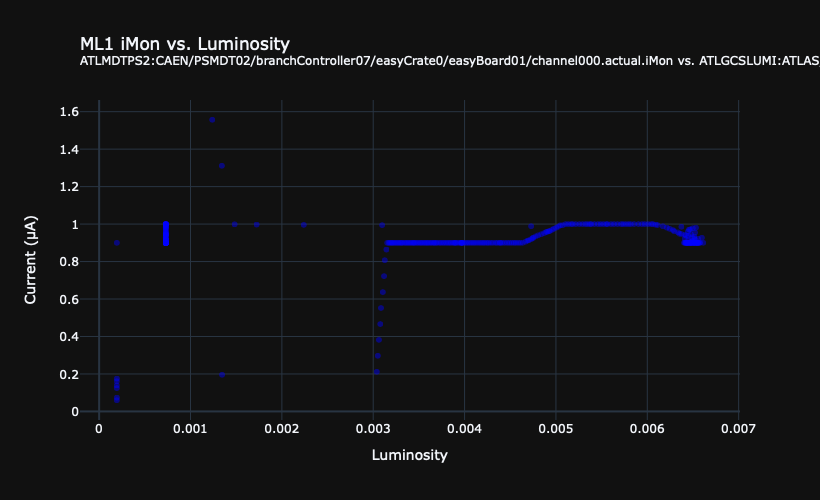

In [187]:
chamber = 'BIL1A01'
chamber_query = f'{chamber} ML1 HV Imon'
chamber_query = pbeast_mapping_df[pbeast_mapping_df['comment_'].str.contains(chamber_query)]['element_name'].values[0]
print(chamber_query)
lumi_query = 'ATLGCSLUMI:ATLAS_PREFERRED_LBAv_PHYS_CalibLumi.value'

hltmon = beauty.timeseries(since_dt.tz_convert(None),
                           till_dt.tz_convert(None),
                           'DCS', 'ATLAS_PVSSMDT',
                           'value-number', 
                           chamber_query, 
                           None, 
                           False)[0]

lumi = beauty.timeseries(since_dt.tz_convert(None), 
                         till_dt.tz_convert(None), 
                         'DCS', 
                         'ATLAS_PVSSDCS', 
                         'value-number', 
                         lumi_query, 
                         None, 
                         False)[0]

hv_lumi = hltmon.correlate(lumi)
print(hltmon)
print(lumi)
lumi_plotly(hv_lumi, chamber_query, lumi_query, 1).show()

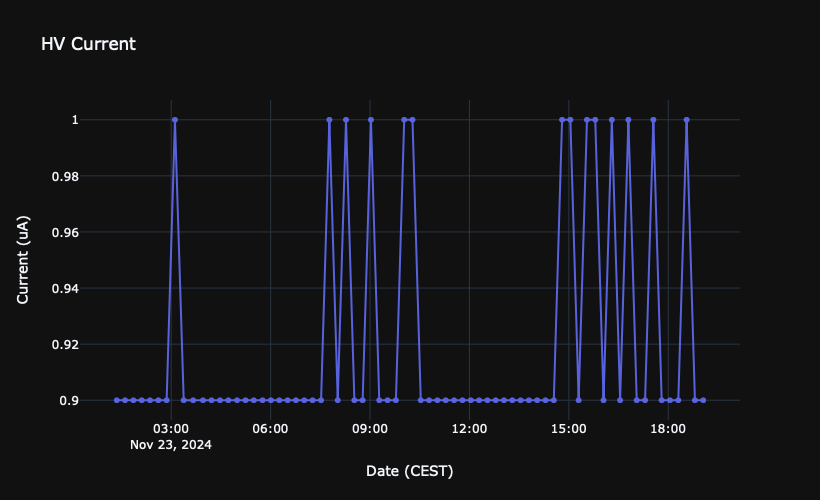

In [185]:
mdt_hvImon_queryData = db.get_data('DCS', 'ATLAS_PVSSMDT', 'value-number', 'ATLMDTPS2:CAEN/PSMDT02/branchController00/easyCrate0/easyBoard01/channel001.actual.iMon', True, since_ts, till_ts, 0, True)
md_hvImon_df = queryDataToDataFrame(mdt_hvImon_queryData)
md_hvImon_df.sort_values(by=['ts'], inplace=True)

t = pd.to_datetime(md_hvImon_df['ts'], unit = 'us', utc = True).dt.tz_convert('Europe/Zurich')
y = md_hvImon_df['value'].astype('float64')

time_plotly([(t, y, 'HV Current')], since_dt, till_dt, 'HV Current', 'Current (uA)').show()

In [53]:
chamber = 'BIL1A01'

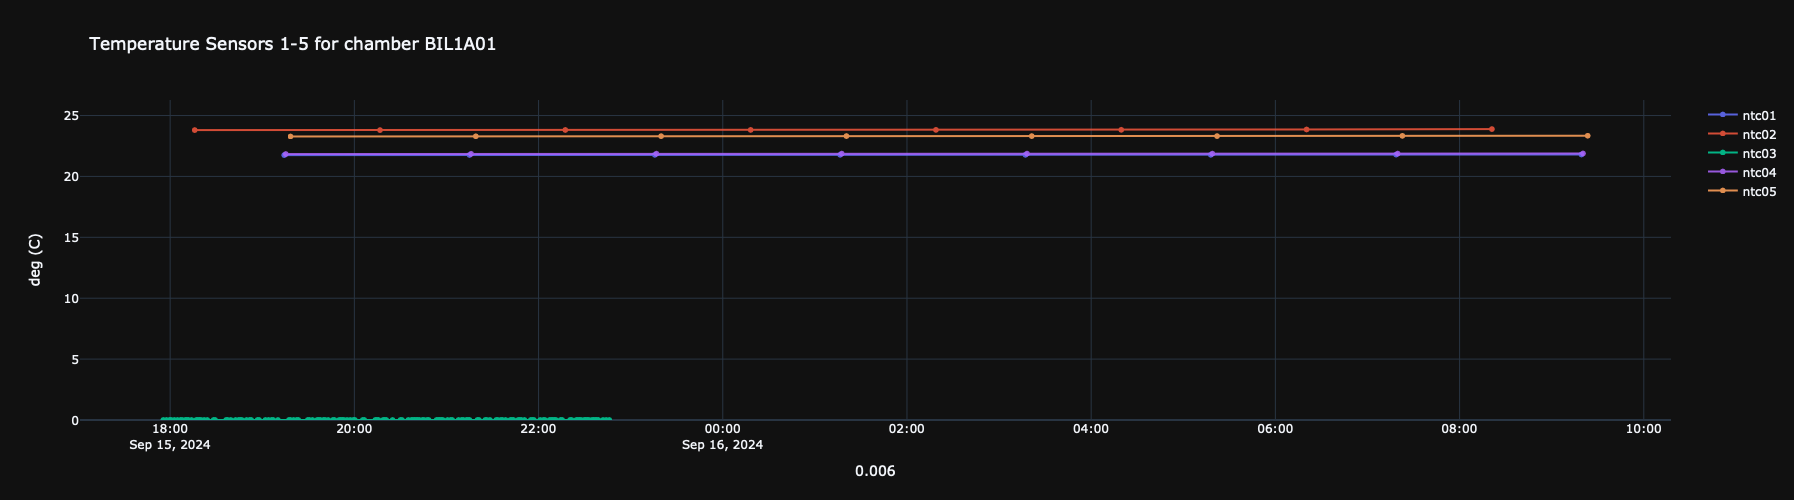

In [54]:
mdt_chamber_ntc01_df = db.get_data('DCS', 'ATLAS_PVSSMDT', 'value-number', f'.*{chamber}.*.ntc.ntc01.*', True, since_ts, till_ts, 0, True)
mdt_chamber_ntc02_df = db.get_data('DCS', 'ATLAS_PVSSMDT', 'value-number', f'.*{chamber}.*.ntc.ntc02.*', True, since_ts, till_ts, 0, True)
mdt_chamber_ntc03_df = db.get_data('DCS', 'ATLAS_PVSSMDT', 'value-number', f'.*{chamber}.*.ntc.ntc03.*', True, since_ts, till_ts, 0, True)
mdt_chamber_ntc04_df = db.get_data('DCS', 'ATLAS_PVSSMDT', 'value-number', f'.*{chamber}.*.ntc.ntc04.*', True, since_ts, till_ts, 0, True)
mdt_chamber_ntc05_df = db.get_data('DCS', 'ATLAS_PVSSMDT', 'value-number', f'.*{chamber}.*.ntc.ntc05.*', True, since_ts, till_ts, 0, True)

mdt_chamber_ntc01 = queryDataToDataFrame(mdt_chamber_ntc01_df)
mdt_chamber_ntc02 = queryDataToDataFrame(mdt_chamber_ntc02_df)
mdt_chamber_ntc03 = queryDataToDataFrame(mdt_chamber_ntc03_df)
mdt_chamber_ntc04 = queryDataToDataFrame(mdt_chamber_ntc04_df)
mdt_chamber_ntc05 = queryDataToDataFrame(mdt_chamber_ntc05_df)

mdt_chamber_ntc01.sort_values(by=['ts'], inplace=True)
mdt_chamber_ntc02.sort_values(by=['ts'], inplace=True)
mdt_chamber_ntc03.sort_values(by=['ts'], inplace=True)
mdt_chamber_ntc04.sort_values(by=['ts'], inplace=True)
mdt_chamber_ntc05.sort_values(by=['ts'], inplace=True)

t1 = pd.to_datetime(mdt_chamber_ntc01['ts'], unit = 'us', utc = True).dt.tz_convert('Europe/Zurich')
y1 = mdt_chamber_ntc01['value'].astype('float64')
y1 = y1[y1 < 10000]
l1 = 'ntc01'

t2 = pd.to_datetime(mdt_chamber_ntc02['ts'], unit = 'us', utc = True).dt.tz_convert('Europe/Zurich')
y2 = mdt_chamber_ntc02['value'].astype('float64')
y2 = y2[y2 < 10000]
l2 = 'ntc02'

t3 = pd.to_datetime(mdt_chamber_ntc03['ts'], unit = 'us', utc = True).dt.tz_convert('Europe/Zurich')
y3 = mdt_chamber_ntc03['value'].astype('float64')
y3 = y3[y3 < 10000]
l3 = 'ntc03'

t4 = pd.to_datetime(mdt_chamber_ntc04['ts'], unit = 'us', utc = True).dt.tz_convert('Europe/Zurich')
y4 = mdt_chamber_ntc04['value'].astype('float64')
y4 = y4[y4 < 10000]
l4 = 'ntc04'

t5 = pd.to_datetime(mdt_chamber_ntc05['ts'], unit = 'us', utc = True).dt.tz_convert('Europe/Zurich')
y5 = mdt_chamber_ntc05['value'].astype('float64')
y5 = y5[y5 < 10000]
l5 = 'ntc05'

tsys = [(t1, y1, l1), (t2, y2, l2), (t3, y3, l3), (t4, y4, l4), (t5, y5, l5)]

time_plotly(tsys, since_dt, till_dt, 
                    f'Temperature Sensors 1-5 for chamber {chamber}', 'deg (C)', True, .006).show()

In [55]:
temp_sensors_df = db.get_data('DCS', 
                              'ATLAS_PVSSMDT', 
                              'value-number', 
                              f'.*{chamber}.*.ntc.*', 
                              True, 
                              since_ts, 
                              till_ts, 
                              0, 
                              True)

temp_sensors_df = queryDataToDataFrame(temp_sensors_df)
temp_sensors_df.sort_values(by=['ts'], inplace=True)
temp_sensors_df['dt'] = pd.to_datetime(temp_sensors_df['ts'], unit = 'us', utc = True).dt.tz_convert('Europe/Zurich')
temp_sensors_df['value'] = temp_sensors_df['value'].astype('float64')
temp_sensors_df['Sensor'] = temp_sensors_df['datapoint'].apply(lambda x : x.split('.')[-2]).apply(lambda x : list(x)[-2:]).apply(lambda x : int(''.join(x)))

In [56]:
temp_sensors_df

datapoint                ts      value  \
25   ATLMDTMDM1:BIL1A01.ntc.ntc03.value  1726415732240000  16662.000   
0    ATLMDTMDM1:BIL1A01.ntc.ntc00.value  1726415793563000     21.124   
26   ATLMDTMDM1:BIL1A01.ntc.ntc03.value  1726415854886000  16656.400   
27   ATLMDTMDM1:BIL1A01.ntc.ntc03.value  1726415977670000      0.000   
28   ATLMDTMDM1:BIL1A01.ntc.ntc03.value  1726416038998000  16656.400   
..                                  ...               ...        ...   
568  ATLMDTMDM1:BIL1A01.ntc.ntc03.value  1726473433558000      0.000   
569  ATLMDTMDM1:BIL1A01.ntc.ntc03.value  1726473494870000  16662.000   
570  ATLMDTMDM1:BIL1A01.ntc.ntc03.value  1726473617667000  16656.400   
8    ATLMDTMDM1:BIL1A01.ntc.ntc00.value  1726473740510000     21.155   
571  ATLMDTMDM1:BIL1A01.ntc.ntc03.value  1726473863257000  16662.000   

                                  dt  Sensor  
25  2024-09-15 17:55:32.240000+02:00       3  
0   2024-09-15 17:56:33.563000+02:00       0  
26  2024-09-15 17:57:34.886000+02:00       3  
27  2024-09-15 17:59:37.670000+02:00       3  
28  2024-09-15 18:00:38.998000+02:00       3  
..                               ...     ...  
568 2024-09-16 09:57:13.558000+02:00       3  
569 2024-09-16 09:58:14.870000+02:00       3  
570 2024-09-16 10:00:17.667000+02:00       3  
8   2024-09-16 10:02:20.510000+02:00       0  
571 2024-09-16 10:04:23.257000+02:00       3  

[588 rows x 5 columns]

In [57]:
sensors = np.sort(temp_sensors_df['Sensor'].unique())

In [58]:
def generate_temp_tsys(temp_sensors_df, sensors):

    tsys = []
    bad_chambers = []
    bad_sensors = []
    temp_sum = 0
    temp_len = 0

    for sensor in sensors:
    
        tmp_df = temp_sensors_df[temp_sensors_df['Sensor'] == sensor]
    
        temp = tmp_df['value']
        dt = tmp_df['dt']
        l = 'Sensor ' + str(sensor)
        
        if len(temp[(temp < 1) | (temp > 200)]) != 0:

            bad_chambers.append(chamber)
            bad_sensors.append(sensor)  
            
        else:

            temp_sum += sum(temp)
            temp_len += len(temp)
    
            tsys.append((dt, temp, l))

    bad_sensors_df = pd.DataFrame({'Chamber' : bad_chambers, 'Faulty Sensor' : bad_sensors})

    avg_temp = temp_sum/temp_len

    for ts, ys, ls, in tsys:

        avg_temp
            
    return tsys, bad_sensors_df, avg_temp

In [59]:
tsys, bad_sensors_df, avg_temp = generate_temp_tsys(temp_sensors_df, sensors)

In [60]:
bad_sensors_df

Chamber  Faulty Sensor
0  BIL1A01              3

In [61]:
avg_temp

22.35219512195122

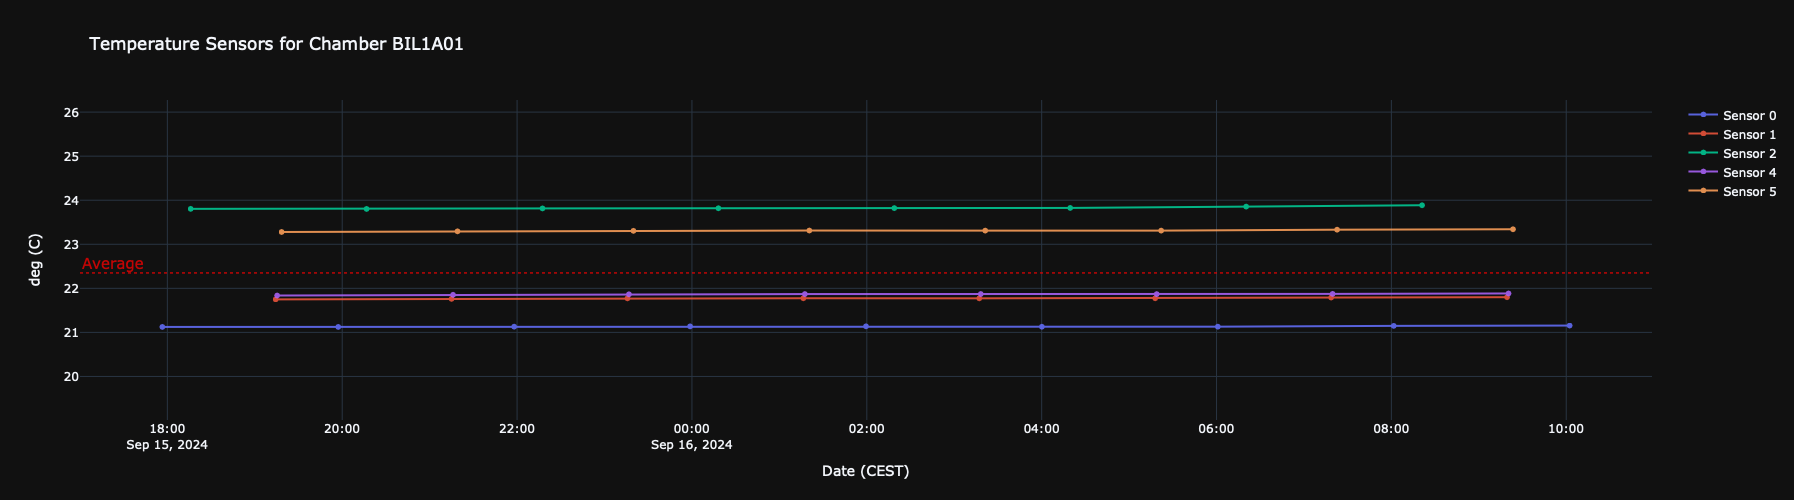

In [62]:
time_plotly(tsys, since_dt, till_dt, f'Temperature Sensors for Chamber {chamber}', 'deg (C)', True, 'Date (CEST)', avg = avg_temp).show()

In [63]:
lumi1 = beauty.timeseries(since_dt.tz_convert(None), 
                          till_dt.tz_convert(None), 
                          'DCS', 
                          'ATLAS_PVSSDCS', 
                          'value-number', 
                          'ATLGCSLUMI:ATLAS_PREFERRED_LBAv_PHYS_CalibLumi.value', 
                          None, 
                          False)[0]

In [64]:
lumi2 = query_lib_data(since_ts, till_ts, 'ATLGCSLUMI:ATLAS_PREFERRED_LBAv_PHYS_CalibLumi.value')
lumi2['value'] = lumi2['value'].astype('float64')

In [65]:
lumi1

2024-09-15 15:55:01.873000+02:00        0.502416
2024-09-15 15:56:01.974000+02:00        0.504054
2024-09-15 15:57:01.976000+02:00        0.503084
2024-09-15 15:58:01.976000+02:00        0.504028
2024-09-15 15:59:01.978000+02:00        0.506359
                                        ...     
2024-09-16 07:57:47.994000+02:00    14100.500000
2024-09-16 07:59:36.008000+02:00    14079.400000
2024-09-16 08:00:36.210000+02:00    14050.100000
2024-09-16 08:02:36.011000+02:00    14035.800000
2024-09-16 08:03:29.907000+02:00    14014.200000
Name: ATLGCSLUMI:ATLAS_PREFERRED_LBAv_PHYS_CalibLumi.value, Length: 861, dtype: float64

In [66]:
lumi2

datapoint                ts  \
0    ATLGCSLUMI:ATLAS_PREFERRED_LBAv_PHYS_CalibLumi...  1726415848516000   
1    ATLGCSLUMI:ATLAS_PREFERRED_LBAv_PHYS_CalibLumi...  1726415873318000   
2    ATLGCSLUMI:ATLAS_PREFERRED_LBAv_PHYS_CalibLumi...  1726415933618000   
3    ATLGCSLUMI:ATLAS_PREFERRED_LBAv_PHYS_CalibLumi...  1726416016813000   
4    ATLGCSLUMI:ATLAS_PREFERRED_LBAv_PHYS_CalibLumi...  1726416088222000   
..                                                 ...               ...   
826  ATLGCSLUMI:ATLAS_PREFERRED_LBAv_PHYS_CalibLumi...  1726470436894000   
827  ATLGCSLUMI:ATLAS_PREFERRED_LBAv_PHYS_CalibLumi...  1726470473184000   
828  ATLGCSLUMI:ATLAS_PREFERRED_LBAv_PHYS_CalibLumi...  1726470490593000   
829  ATLGCSLUMI:ATLAS_PREFERRED_LBAv_PHYS_CalibLumi...  1726470500692000   
830  ATLGCSLUMI:ATLAS_PREFERRED_LBAv_PHYS_CalibLumi...  1726470560697000   

            value                               dt  
0        0.351722 2024-09-15 17:57:28.516000+02:00  
1        0.354164 2024-09-15 17:57:53.318000+02:00  
2        0.355398 2024-09-15 17:58:53.618000+02:00  
3        0.356278 2024-09-15 18:00:16.813000+02:00  
4        0.356995 2024-09-15 18:01:28.222000+02:00  
..            ...                              ...  
826  12676.800000 2024-09-16 09:07:16.894000+02:00  
827   9146.700000 2024-09-16 09:07:53.184000+02:00  
828      0.338661 2024-09-16 09:08:10.593000+02:00  
829      0.310262 2024-09-16 09:08:20.692000+02:00  
830      0.293211 2024-09-16 09:09:20.697000+02:00  

[831 rows x 4 columns]

In [67]:
lbn1 = beauty.timeseries(since_dt.tz_convert(None), 
                         till_dt.tz_convert(None), 
                         'DCS', 
                         'ATLAS_PVSSDCS', 
                         'value-number', 
                         'ATLGCSDDC:daqLumiBlockNumber.value', 
                         None, 
                         False)[0]

In [68]:
lbn2 = query_lib_data(since_ts, till_ts, 'ATLGCSDDC:daqLumiBlockNumber.value')
lbn2['value'] = lbn2['value'].astype('float64')

In [69]:
lbn1

2024-09-15 15:54:56.454000+02:00      62.0
2024-09-15 15:55:56.566000+02:00      63.0
2024-09-15 15:56:56.569000+02:00      64.0
2024-09-15 15:57:56.663000+02:00      65.0
2024-09-15 15:58:56.659000+02:00      66.0
                                     ...  
2024-09-16 08:01:30.706000+02:00    1066.0
2024-09-16 08:02:30.703000+02:00    1067.0
2024-09-16 08:02:43.226000+02:00    1068.0
2024-09-16 08:03:24.395000+02:00    1069.0
2024-09-16 08:04:03.261000+02:00    1070.0
Name: ATLGCSDDC:daqLumiBlockNumber.value, Length: 1196, dtype: float64

In [70]:
lbn2

datapoint                ts   value  \
0     ATLGCSDDC:daqLumiBlockNumber.value  1726415754594000     0.0   
1     ATLGCSDDC:daqLumiBlockNumber.value  1726415816395000     1.0   
2     ATLGCSDDC:daqLumiBlockNumber.value  1726415843240000     2.0   
3     ATLGCSDDC:daqLumiBlockNumber.value  1726415867979000     3.0   
4     ATLGCSDDC:daqLumiBlockNumber.value  1726415928288000     4.0   
...                                  ...               ...     ...   
1178  ATLGCSDDC:daqLumiBlockNumber.value  1726470735653000  1178.0   
1179  ATLGCSDDC:daqLumiBlockNumber.value  1726470795754000  1179.0   
1180  ATLGCSDDC:daqLumiBlockNumber.value  1726470960615000  1179.0   
1181  ATLGCSDDC:daqLumiBlockNumber.value  1726470960615001  1179.0   
1182  ATLGCSDDC:daqLumiBlockNumber.value  1726473842544000  1179.0   

                                   dt  
0    2024-09-15 17:55:54.594000+02:00  
1    2024-09-15 17:56:56.395000+02:00  
2    2024-09-15 17:57:23.240000+02:00  
3    2024-09-15 17:57:47.979000+02:00  
4    2024-09-15 17:58:48.288000+02:00  
...                               ...  
1178 2024-09-16 09:12:15.653000+02:00  
1179 2024-09-16 09:13:15.754000+02:00  
1180 2024-09-16 09:16:00.615000+02:00  
1181 2024-09-16 09:16:00.615001+02:00  
1182 2024-09-16 10:04:02.544000+02:00  

[1183 rows x 4 columns]

In [71]:
lbns = []
lbn_tss = []
lumis = []
lumi_tss = []

j = 0

for i in range(lbn2.shape[0] - 1):

    lbn_ts = lbn2['ts'].iloc[i]

    lumi_ts = lumi2['ts'].iloc[j]

    while lumi_ts < lbn_ts:

        if j < lumi2.shape[0] - 1:

            j += 1
        
            lumi_ts = lumi2['ts'].iloc[j]

        else:

            break
    
    lbns.append(lbn2['value'].iloc[i])
    lbn_tss.append(lbn_ts)
    lumis.append(lumi2['value'].iloc[j])
    lumi_tss.append(lumi_ts)


dic_tmp = {'LumiBlock Number' : lbns, 'Lumiblock ts' : lbn_tss, 'Luminosity' : lumis, 'Luminosity ts' : lumi_tss}

lbn_lumi_df = pd.DataFrame(dic_tmp)

In [72]:
lbn_lumi_df

LumiBlock Number      Lumiblock ts  Luminosity     Luminosity ts
0                  0.0  1726415754594000    0.351722  1726415848516000
1                  1.0  1726415816395000    0.351722  1726415848516000
2                  2.0  1726415843240000    0.351722  1726415848516000
3                  3.0  1726415867979000    0.354164  1726415873318000
4                  4.0  1726415928288000    0.355398  1726415933618000
...                ...               ...         ...               ...
1177            1177.0  1726470675651000    0.293211  1726470560697000
1178            1178.0  1726470735653000    0.293211  1726470560697000
1179            1179.0  1726470795754000    0.293211  1726470560697000
1180            1179.0  1726470960615000    0.293211  1726470560697000
1181            1179.0  1726470960615001    0.293211  1726470560697000

[1182 rows x 4 columns]

In [73]:
t1 = lbn_lumi_df['LumiBlock Number']
y1 = lbn_lumi_df['Luminosity']

In [74]:
options = ["JTAG", "HV", "LV"]

if len(options) == 0:

    st.write('Please Select an FSM Type')

    st.stop()

string_tmp = ''

for option in options:

    if string_tmp != '':

        string_tmp += '|'

    if option == 'HV':

        string_tmp += '.*_ML1.*fsm.currentState|.*_ML2.*fsm.currentState'

    else:

        string_tmp += '.*_' + option + '.*fsm.currentState'

mdt_fsm_status_df = query_lib_data(since_ts, till_ts, string_tmp, 'MDT', 'string')


In [75]:
# lumiblock_plotly([(t1, y1, 'Lumi')], 
#                  lbn_sb_fsm_flags_df, 
#                  since_dt, 
#                  till_dt, 
#                  'Lumi vs. Lumiblock', 
#                  'Luminosity (W)', 
#                  True, 
#                  'LumiBlock Number', 
#                  .03, 
#                  [sb_lb_start], 
#                  [sb_lb_end]).show()

In [76]:
lbn_sb_fsm_flags_df.head(2)

LumiBlock Number                    FSM Datapoint           FSM Flag  \
0               516  MDM5:MDT_ECC_JTAG_OUTER|EOS3C02           'FAILED'   
1               878  MDM4:MDT_ECA_JTAG_OUTER|EOL5A01  'NOT_INITIALIZED'   

   Stable Beam  Ready 4 Physics                     LumiBlock dt  \
0            1                1 2024-09-16 00:05:18.327000+02:00   
1            1                1 2024-09-16 05:23:48.937000+02:00   

                            FSM dt  Chamber Partition  Info Sector  
0 2024-09-16 00:05:37.163000+02:00  EOS3C02      EC01  JTAG     EC  
1 2024-09-16 05:24:01.885000+02:00  EOL5A01      EA01  JTAG     EA

In [77]:
ts_start_dt = '2024-07-01 00:00:00'
ts_end_dt = '2024-07-03 00:00:00'

fmt = '%Y-%m-%d %H:%M:%S'                                       # For user input in the sidebar


since_dt = dt.strptime(ts_start_dt, fmt)
till_dt = dt.strptime(ts_end_dt, fmt)

since_ts = int((pd.to_datetime(ts_start_dt)).timestamp()*1e6)       # Convert these to timestamps, convert to us, convert to int
till_ts = int((pd.to_datetime(ts_end_dt)).timestamp()*1e6)

two_hrs_in_us = int(2*60*60*1e6)                                 # 2 hrs * 60 min * 60 s * 1e6 us

since_dt = pd.Timestamp.fromtimestamp((since_ts-two_hrs_in_us)/1e6).tz_localize('UTC').tz_convert('Europe/Zurich')
till_dt = pd.Timestamp.fromtimestamp((till_ts-two_hrs_in_us)/1e6).tz_localize('UTC').tz_convert('Europe/Zurich')

In [78]:
sb_since_dt = since_dt + timedelta(hours = 2)

sb_till_dt = till_dt + timedelta(hours=2)

sbFlag = beauty.timeseries(sb_since_dt.tz_convert(None), 
                           sb_till_dt.tz_convert(None), 
                           'DCS', 
                           'ATLAS_PVSSDCS', 
                           'value-number', 
                           'ATLGCSLHC:bit_lhc_RunCtrl_SafeBeam_StableBeams.value', 
                           None, 
                           False)[0]

sb_df = pd.DataFrame({'value': sbFlag.array , 'dt': sbFlag.index})
sb_df['value'] = sb_df['value'].astype(float).astype(int)
sb_df['ts'] = sb_df['dt'].values.astype(int) // 10**3

In [79]:
sb_df

value                               dt                ts
0      0 2024-07-01 02:07:21.525000+02:00  1719792441525000
1      1 2024-07-01 09:24:00.687000+02:00  1719818640687000
2      0 2024-07-01 11:48:33.741000+02:00  1719827313741000
3      1 2024-07-01 16:35:46.849000+02:00  1719844546849000
4      0 2024-07-01 21:22:06.955000+02:00  1719861726955000
5      1 2024-07-01 23:54:04.012000+02:00  1719870844012000
6      0 2024-07-02 15:10:31.353000+02:00  1719925831353000
7      1 2024-07-02 23:50:56.547000+02:00  1719957056547000
8      0 2024-07-03 00:24:36.560000+02:00  1719959076560000

In [80]:
if sb_df.shape[0] >= 2:

    if sb_df.iloc[0]['value'] == 0:
    
        sb_df = sb_df.iloc[1:]

    if sb_df.iloc[-1]['value'] == 1:
    
        sb_df = sb_df.iloc[:-1]

In [81]:
sb_df.reset_index(drop=True, inplace=True)
sb_df

value                               dt                ts
0      1 2024-07-01 09:24:00.687000+02:00  1719818640687000
1      0 2024-07-01 11:48:33.741000+02:00  1719827313741000
2      1 2024-07-01 16:35:46.849000+02:00  1719844546849000
3      0 2024-07-01 21:22:06.955000+02:00  1719861726955000
4      1 2024-07-01 23:54:04.012000+02:00  1719870844012000
5      0 2024-07-02 15:10:31.353000+02:00  1719925831353000
6      1 2024-07-02 23:50:56.547000+02:00  1719957056547000
7      0 2024-07-03 00:24:36.560000+02:00  1719959076560000

In [82]:
if sb_df.shape[0] >= 2:

    sb_starts = sb_df[sb_df['value'] == 1]['dt'].tolist()

    sb_ends = sb_df[sb_df['value'] == 0]['dt'].tolist()

sb_starts

[Timestamp('2024-07-01 09:24:00.687000+0200', tz='Europe/Zurich'),
 Timestamp('2024-07-01 16:35:46.849000+0200', tz='Europe/Zurich'),
 Timestamp('2024-07-01 23:54:04.012000+0200', tz='Europe/Zurich'),
 Timestamp('2024-07-02 23:50:56.547000+0200', tz='Europe/Zurich')]

In [83]:
sb_ends

[Timestamp('2024-07-01 11:48:33.741000+0200', tz='Europe/Zurich'),
 Timestamp('2024-07-01 21:22:06.955000+0200', tz='Europe/Zurich'),
 Timestamp('2024-07-02 15:10:31.353000+0200', tz='Europe/Zurich'),
 Timestamp('2024-07-03 00:24:36.560000+0200', tz='Europe/Zurich')]

In [84]:
lbn_sb_fsm_flags_df.head()

LumiBlock Number                    FSM Datapoint           FSM Flag  \
0               516  MDM5:MDT_ECC_JTAG_OUTER|EOS3C02           'FAILED'   
1               878  MDM4:MDT_ECA_JTAG_OUTER|EOL5A01  'NOT_INITIALIZED'   
2               878  MDM4:MDT_ECA_JTAG_OUTER|EOL3A03  'NOT_INITIALIZED'   
3               878  MDM4:MDT_ECA_JTAG_OUTER|EOS3A04  'NOT_INITIALIZED'   
4               878  MDM4:MDT_ECA_JTAG_OUTER|EOS6A04  'NOT_INITIALIZED'   

   Stable Beam  Ready 4 Physics                     LumiBlock dt  \
0            1                1 2024-09-16 00:05:18.327000+02:00   
1            1                1 2024-09-16 05:23:48.937000+02:00   
2            1                1 2024-09-16 05:23:48.937000+02:00   
3            1                1 2024-09-16 05:23:48.937000+02:00   
4            1                1 2024-09-16 05:23:48.937000+02:00   

                            FSM dt  Chamber Partition  Info Sector  
0 2024-09-16 00:05:37.163000+02:00  EOS3C02      EC01  JTAG     EC  
1 2024-09-16 05:24:01.885000+02:00  EOL5A01      EA01  JTAG     EA  
2 2024-09-16 05:24:01.885000+02:00  EOL3A03      EA01  JTAG     EA  
3 2024-09-16 05:24:01.885000+02:00  EOS3A04      EA01  JTAG     EA  
4 2024-09-16 05:24:01.885000+02:00  EOS6A04      EA01  JTAG     EA

In [85]:
fsm_sb_df = lbn_sb_fsm_flags_df[lbn_sb_fsm_flags_df['Stable Beam'] == 1]
fsm_jtag_df = fsm_sb_df[fsm_sb_df['Info'] == 'JTAG']
fsm_hv_df = fsm_sb_df[(fsm_sb_df['Info'] == 'ML1') | (fsm_sb_df['Info'] == 'ML2')]
fsm_lv_df = fsm_sb_df[fsm_sb_df['Info'] == 'LV']

In [86]:
sb_range = list(range(sb_lb_start, sb_lb_end))
print(type(sb_range))

<class 'list'>


In [87]:
fsm_jtag_df.head()

LumiBlock Number                    FSM Datapoint           FSM Flag  \
0               516  MDM5:MDT_ECC_JTAG_OUTER|EOS3C02           'FAILED'   
1               878  MDM4:MDT_ECA_JTAG_OUTER|EOL5A01  'NOT_INITIALIZED'   
2               878  MDM4:MDT_ECA_JTAG_OUTER|EOL3A03  'NOT_INITIALIZED'   
3               878  MDM4:MDT_ECA_JTAG_OUTER|EOS3A04  'NOT_INITIALIZED'   
4               878  MDM4:MDT_ECA_JTAG_OUTER|EOS6A04  'NOT_INITIALIZED'   

   Stable Beam  Ready 4 Physics                     LumiBlock dt  \
0            1                1 2024-09-16 00:05:18.327000+02:00   
1            1                1 2024-09-16 05:23:48.937000+02:00   
2            1                1 2024-09-16 05:23:48.937000+02:00   
3            1                1 2024-09-16 05:23:48.937000+02:00   
4            1                1 2024-09-16 05:23:48.937000+02:00   

                            FSM dt  Chamber Partition  Info Sector  
0 2024-09-16 00:05:37.163000+02:00  EOS3C02      EC01  JTAG     EC  
1 2024-09-16 05:24:01.885000+02:00  EOL5A01      EA01  JTAG     EA  
2 2024-09-16 05:24:01.885000+02:00  EOL3A03      EA01  JTAG     EA  
3 2024-09-16 05:24:01.885000+02:00  EOS3A04      EA01  JTAG     EA  
4 2024-09-16 05:24:01.885000+02:00  EOS6A04      EA01  JTAG     EA

In [88]:
fsm_lbns = fsm_jtag_df['LumiBlock Number'].unique()
number_of_chambers = 1112

j = 0

fsm_jtag_percentages = []
number_of_errors = 0

for i in sb_range:

    if i in fsm_lbns:

        fsm_lbn = int(fsm_lbns[j])

        number_of_errors = fsm_jtag_df[fsm_jtag_df['LumiBlock Number'] == i].shape[0]

        fsm_jtag_percentage = (number_of_chambers - number_of_errors) / number_of_chambers * 100

        fsm_jtag_percentages.append(fsm_jtag_percentage)

        j += 1

    else:

        fsm_jtag_percentages.append(100.0)

In [89]:
fsm_lbns = fsm_hv_df['LumiBlock Number'].unique()

j = 0

fsm_hv_percentages = []
number_of_errors = 0

for i in sb_range:

    if i in fsm_lbns:

        fsm_lbn = int(fsm_lbns[j])

        number_of_errors = fsm_hv_df[fsm_hv_df['LumiBlock Number'] == i].shape[0]

        fsm_hv_percentage = (number_of_chambers - number_of_errors) / number_of_chambers * 100

        fsm_hv_percentages.append(fsm_hv_percentage)

        j += 1

    else:

        fsm_hv_percentages.append(100.0)

In [90]:
fsm_lbns = fsm_lv_df['LumiBlock Number'].unique()

j = 0

fsm_lv_percentages = []
number_of_errors = 0

for i in sb_range:

    if i in fsm_lbns:

        fsm_lbn = int(fsm_lbns[j])

        number_of_errors = fsm_lv_df[fsm_lv_df['LumiBlock Number'] == i].shape[0]

        fsm_lv_percentage = (number_of_chambers - number_of_errors) / number_of_chambers * 100

        fsm_lv_percentages.append(fsm_lv_percentage)

        j += 1

    else:

        fsm_lv_percentages.append(100.0)

In [91]:
percentages_df = pd.DataFrame({'Stable Beam LumiBlock Number' : sb_range, 'JTAG DQ Percentage' : fsm_jtag_percentages, 'HV DQ Percentage' : fsm_hv_percentages, 'LV DQ Percentage' : fsm_lv_percentages})

In [92]:
percentages_df.head()

Stable Beam LumiBlock Number  JTAG DQ Percentage  HV DQ Percentage  \
0                            62               100.0             100.0   
1                            63               100.0             100.0   
2                            64               100.0             100.0   
3                            65               100.0             100.0   
4                            66               100.0             100.0   

   LV DQ Percentage  
0             100.0  
1             100.0  
2             100.0  
3             100.0  
4             100.0

In [93]:
sb_range = percentages_df['Stable Beam LumiBlock Number'].values.tolist()

percentages = [(sb_range, percentages_df['JTAG DQ Percentage'].values.tolist(), 'JTAG DQ Percentage'), (sb_range, percentages_df['HV DQ Percentage'].values.tolist(), 'HV DQ Percentage'), (sb_range, percentages_df['LV DQ Percentage'].values.tolist(), 'LV DQ Percentage')]

In [94]:
# percentages = [(sb_range, fsm_jtag_percentages, 'JTAG DQ Percentage'), (sb_range, fsm_hv_percentages, 'HV DQ Percentage'), (sb_range, fsm_lv_percentages, 'LV DQ Percentage')]

In [95]:
# lumiblock_plotly([(t1, y1, 'Lumi')], 
#                  lbn_sb_fsm_flags_df, 
#                  since_dt, 
#                  till_dt, 
#                  'Lumi vs. Lumiblock', 
#                  'Luminosity (W)', 
#                  True, 
#                  'LumiBlock Number', 
#                  .03, 
#                  [sb_lb_start], 
#                  [sb_lb_end],
#                  False,
#                  percentages).show()

In [96]:
# percentages

In [97]:
run_num = 489691

ts_start_dt = rn_sb_df[rn_sb_df['Stable Beam Run Number'] == run_num]['Run Start dt'].iloc[0]
ts_end_dt = rn_sb_df[rn_sb_df['Stable Beam Run Number'] == run_num]['Run End dt'].iloc[0]

since_ts = int((pd.to_datetime(ts_start_dt)).timestamp()*1e6)
till_ts = int((pd.to_datetime(ts_end_dt)).timestamp()*1e6)

since_dt = pd.Timestamp.fromtimestamp((since_ts-7200000000)/1e6).tz_localize('UTC').tz_convert('Europe/Zurich')
till_dt = pd.Timestamp.fromtimestamp((till_ts-7200000000)/1e6).tz_localize('UTC').tz_convert('Europe/Zurich')

ts_start_dt.strftime('%Y-%m-%d %H:%M:%S')

'2024-11-16 10:33:34'

In [98]:
##### This works!! #####


start_dt = '2024-11-14 10:28:00.005000+0100' # from atlas-datasummary.web.cern.ch
end_dt = '2024-11-14 11:50:34.005000+0100'

fmt = '%Y-%m-%d %H:%M:%S.%f%z'

since_dt = dt.strptime(start_dt, fmt)
till_dt = dt.strptime(end_dt, fmt)

since_ts = int((pd.to_datetime(since_dt)).timestamp()*1e6)
till_ts = int((pd.to_datetime(till_dt)).timestamp()*1e6)

since_dt.strftime('%Y-%m-%d %H:%M:%S')
print(since_ts)

1731576480005000


In [99]:
mdt_mrod_df_raw = db.get_data('DCS', 'ATLAS_PVSSMDT', 'value-number', '.*mdtMrod_.*.Status.*', True, since_ts, till_ts, 0, True)

# function to analysis the MROD dataframe
mdt_mrod_df = queryDataToDataFrame(mdt_mrod_df_raw)
# crate date column
mdt_mrod_df['dt'] = pd.to_datetime(mdt_mrod_df['ts'], unit = 'us', utc = True).dt.tz_convert('Europe/Zurich')
mdt_mrod_df['value'] = mdt_mrod_df['value'].astype(float).astype(int)
mdt_mrod_df

# filter stopless removed MROD
# condition = mdt_mrod_df['value'].astype(float) > 0
# mdt_mrod_df = mdt_mrod_df[condition]
mdt_mrod_df.sort_values(by='ts', ascending=True, inplace = True)
# removed_df = mdt_mrod_df[mdt_mrod_df['datapoint'].str.contains('Removed')]
# len(removed_df)
mdt_mrod_df

datapoint                ts  value  \
0  ATLMDTPS2:CAEN/PSMDT02/branchController00/easy...  1731576515237000      0   
1  ATLMDTPS2:CAEN/PSMDT02/branchController00/easy...  1731577447951000      0   
2  ATLMDTPS2:CAEN/PSMDT02/branchController00/easy...  1731578405771000      0   
3  ATLMDTPS2:CAEN/PSMDT02/branchController00/easy...  1731580101575000      0   
4  ATLMDTPS2:CAEN/PSMDT02/branchController00/easy...  1731581193424000      0   

                                dt  
0 2024-11-14 10:28:35.237000+01:00  
1 2024-11-14 10:44:07.951000+01:00  
2 2024-11-14 11:00:05.771000+01:00  
3 2024-11-14 11:28:21.575000+01:00  
4 2024-11-14 11:46:33.424000+01:00

In [100]:
busy_df = mdt_mrod_df[mdt_mrod_df['datapoint'].str.contains('Busy')]

In [101]:
def generate_tower_flag_durations_df(df, type):

    unique_datapoints = df['datapoint'][df['value'] != 0].unique()
    
    partitions = []
    towers = []
    start_tss = []
    end_tss = []
    start_dts = []
    end_dts = []
    total_times = []
    total_tower_flags = []
    
    for i in range(len(unique_datapoints)):
    
        unique_datapoint = unique_datapoints[i]
    
        tmp_df = df[df['datapoint'] == unique_datapoint]
        
        tmp_str = tmp_df['datapoint'].values[0][18:28]
    
        partition = tmp_str[:2]
    
        tower = tmp_str[-2:]
    
        tower = tower.replace('.', '')
    
        change_df = tmp_df[tmp_df['value'].diff() != 0].reset_index()

        if change_df.shape[0] != 1:
    
            while change_df.iloc[0]['value'] == 0:
    
                change_df.drop(index = 0, inplace = True)
    
            i = 0

            pairs = int(round(change_df.shape[0]/2-.25))
    
            for _ in range(pairs):
    
                tmp_start_ts = change_df.iloc[i]['ts']
                tmp_end_ts = change_df.iloc[i+1]['ts']
                tmp_start_dt = change_df.iloc[i]['dt']
                tmp_end_dt = change_df.iloc[i+1]['dt']
    
                total_time = tmp_end_dt - tmp_start_dt
    
                partitions.append(partition)
                towers.append(tower)
                start_tss.append(tmp_start_ts)
                end_tss.append(tmp_end_ts)
                start_dts.append(tmp_start_dt)
                end_dts.append(tmp_end_dt)
                total_times.append(total_time)
                total_tower_flags.append(pairs)
    
                i += 2
    
            if change_df.shape[0]%2 != 0:
    
                tmp_start_ts = change_df.iloc[-1]['ts']
                tmp_end_ts = till_ts
                tmp_start_dt = change_df.iloc[-1]['dt']
                tmp_end_dt = till_dt
    
                total_time = tmp_end_dt - tmp_start_dt
        
                partitions.append(partition)
                towers.append(tower)
                start_tss.append(tmp_start_ts)
                end_tss.append(tmp_end_ts)
                start_dts.append(tmp_start_dt)
                end_dts.append(tmp_end_dt)
                total_times.append(total_time)
                total_tower_flags.append(pairs + 1)

    time_total = np.sum(total_times)

    return_df = pd.DataFrame({'Partition' : partitions, 
                              'Tower' : towers, 
                              'Start ts' : start_tss, 
                              'End ts' : end_tss, 
                              'Start dt' : start_dts, 
                              'End dt' : end_dts, 
                              f'Total {type} Time' : total_times,
                              'Total Flags for Tower': total_tower_flags})

    return_df[f'Total {type} Time'] = return_df[f'Total {type} Time'].apply(lambda td: str(td)[7:])

    return return_df, time_total

In [102]:
busy_times_df, total_busy_time = generate_tower_flag_durations_df(busy_df, 'Busy')

In [103]:
busy_times_df.head()

Empty DataFrame
Columns: [Partition, Tower, Start ts, End ts, Start dt, End dt, Total Busy Time, Total Flags for Tower]
Index: []

In [104]:
total_busy_time

0.0

In [105]:
removed_df = mdt_mrod_df[mdt_mrod_df['datapoint'].str.contains('Removed')]

In [106]:
removed_times_df, total_removed_time = generate_tower_flag_durations_df(removed_df, 'Removed')

In [107]:
removed_times_df.head()

Empty DataFrame
Columns: [Partition, Tower, Start ts, End ts, Start dt, End dt, Total Removed Time, Total Flags for Tower]
Index: []

In [108]:
total_removed_time

0.0

In [109]:
mdt_ddc_df_raw = db.get_data('DCS', 
                             'ATLAS_PVSSMDT', 
                             'value-number', 
                             '.*mdtDDC_.*.Status.*', 
                             True, 
                             since_ts, 
                             till_ts, 
                             0, 
                             True)

mdt_ddc_df = queryDataToDataFrame(mdt_ddc_df_raw)

# crate date column
mdt_ddc_df['dt'] = pd.to_datetime(mdt_ddc_df['ts'], unit = 'us', utc = True).dt.tz_convert('Europe/Zurich')
mdt_ddc_df['value'] = mdt_ddc_df['value'].astype(float).astype(int)
mdt_ddc_df['type'] = mdt_ddc_df['datapoint'].apply(lambda x : x.split('.')[-1])

condition = mdt_ddc_df['value'] > 0
dropped_df = mdt_ddc_df[condition]
dropped_df.sort_values(by='ts', ascending = False, inplace = True)

In [110]:
dropped_df.head()

Empty DataFrame
Columns: [datapoint, ts, value, dt, type]
Index: []

In [111]:
def generate_chamber_flag_durations_df(df, type):

    flags = df[df['value'] > 0]
    unique_datapoints = flags['datapoint'].unique()
    
    chambers = []
    start_tss = []
    end_tss = []
    start_dts = []
    end_dts = []
    total_times = []
    total_chamber_flags = []
    
    for i in range(len(unique_datapoints)):
    
        unique_datapoint = unique_datapoints[i]

        # print(unique_datapoint)
    
        tmp_df = df[df['datapoint'] == unique_datapoint]

        # print(tmp_df)
        
        chamber = tmp_df['datapoint'].values[0][17:24]

        # print(tmp_str)
    
        change_df = tmp_df[tmp_df['value'].diff() != 0].reset_index()
        
        if change_df.shape[0] != 1:
    
            while change_df.iloc[0]['value'] == 0:
    
                change_df.drop(index = 0, inplace = True)
    
            i = 0

            pairs = int(round(change_df.shape[0]/2-.25))
    
            for _ in range(pairs):
    
                tmp_start_ts = change_df.iloc[i]['ts']
                tmp_end_ts = change_df.iloc[i+1]['ts']
                tmp_start_dt = change_df.iloc[i]['dt']
                tmp_end_dt = change_df.iloc[i+1]['dt']
    
                total_time = tmp_end_dt - tmp_start_dt
    
                chambers.append(chamber)
                start_tss.append(tmp_start_ts)
                end_tss.append(tmp_end_ts)
                start_dts.append(tmp_start_dt)
                end_dts.append(tmp_end_dt)
                total_times.append(total_time)
                total_chamber_flags.append(pairs)
    
                i += 2
    
            if change_df.shape[0]%2 != 0:
    
                tmp_start_ts = change_df.iloc[-1]['ts']
                tmp_end_ts = till_ts
                tmp_start_dt = change_df.iloc[-1]['dt']
                tmp_end_dt = till_dt
    
                total_time = tmp_end_dt - tmp_start_dt
        
                chambers.append(chamber)
                start_tss.append(tmp_start_ts)
                end_tss.append(tmp_end_ts)
                start_dts.append(tmp_start_dt)
                end_dts.append(tmp_end_dt)
                total_times.append(total_time)
                total_chamber_flags.append(pairs + 1)

    time_total = np.sum(total_times)

    return_df = pd.DataFrame({'Chamber' : chambers, 
                              'Start ts' : start_tss, 
                              'End ts' : end_tss, 
                              'Start dt' : start_dts, 
                              'End dt' : end_dts, 
                              f'Total {type} Time' : total_times,
                              'Total Flags for Chamber': total_chamber_flags})

    return_df[f'Total {type} Time'] = return_df[f'Total {type} Time'].apply(lambda td: str(td)[7:])

    return return_df, time_total

In [112]:
autorecovery_df = mdt_ddc_df[mdt_ddc_df['type'] == "Recovering"].reset_index(drop=True)
autorecovery_df.sort_values(by='ts', inplace = True)

In [113]:
autorecovery_df.head()

Empty DataFrame
Columns: [datapoint, ts, value, dt, type]
Index: []

In [114]:
autorecovery_times_df, total_autorecover_time = generate_chamber_flag_durations_df(autorecovery_df, 'Recovery')

In [115]:
autorecovery_times_df.head()

Empty DataFrame
Columns: [Chamber, Start ts, End ts, Start dt, End dt, Total Recovery Time, Total Flags for Chamber]
Index: []

In [116]:
total_autorecover_time

0.0

In [117]:
dropChamber_df = mdt_ddc_df[mdt_ddc_df['type'] == "Dropped"].reset_index(drop=True)
dropChamber_df.sort_values(by='ts', inplace = True)

In [118]:
dropChamber_df.head()

Empty DataFrame
Columns: [datapoint, ts, value, dt, type]
Index: []

In [119]:
dropChamber_times_df, total_dropped_time = generate_chamber_flag_durations_df(dropChamber_df, 'Drop')

In [120]:
dropChamber_times_df.head()

Empty DataFrame
Columns: [Chamber, Start ts, End ts, Start dt, End dt, Total Drop Time, Total Flags for Chamber]
Index: []

In [121]:
dropMezz_df = mdt_ddc_df[mdt_ddc_df['type'] == "DroppedMezz"].reset_index(drop=True)
dropMezz_df.sort_values(by='ts', inplace = True)
dropMezzNum_df = mdt_ddc_df[mdt_ddc_df['type'] == "DroppedMezzNum"].reset_index(drop=True)
dropMezzNum_df.sort_values(by='ts', inplace = True)
dropMezzMask_df = mdt_ddc_df[(mdt_ddc_df['type'] == "DroppedMezzMask") & (mdt_ddc_df['value'] > 0)].reset_index(drop=True)
dropMezzMask_df.sort_values(by='ts', inplace = True)

In [122]:
dropMezz_df[dropMezz_df['value'] > 0]

Empty DataFrame
Columns: [datapoint, ts, value, dt, type]
Index: []

In [123]:
dropMezzNum_df

Empty DataFrame
Columns: [datapoint, ts, value, dt, type]
Index: []

In [124]:
dropMezzMask_df[dropMezzMask_df['value']>0].iloc[0]['value']

IndexError: single positional indexer is out-of-bounds

In [ ]:
def generate_mezz_flag_durations_df(df, dropMezzNum_df, dropMezzMask_df):

    flags = df[df['value'] > 0]
    unique_datapoints = flags['datapoint'].unique()
    
    chambers = []
    DroppedMezzNums = []
    DroppedMezzMasks = []
    start_tss = []
    end_tss = []
    start_dts = []
    end_dts = []
    total_times = []
    total_mezz_flags = []
    
    for i in range(len(unique_datapoints)):
    
        unique_datapoint = unique_datapoints[i]

        # print(unique_datapoint)
    
        tmp_df = df[df['datapoint'] == unique_datapoint]

        # print(tmp_df)
        
        chamber = tmp_df['datapoint'].values[0][17:24]
    
        change_df = tmp_df[tmp_df['value'].diff() != 0].reset_index()
        
        if change_df.shape[0] != 1:
    
            while change_df.iloc[0]['value'] == 0:
    
                change_df.drop(index = 0, inplace = True)
    
            j = 0

            pairs = int(round(change_df.shape[0]/2-.25))

            for _ in range(pairs):
    
                tmp_start_ts = change_df.iloc[j]['ts']
                tmp_end_ts = change_df.iloc[j+1]['ts']
                tmp_start_dt = change_df.iloc[j]['dt']
                tmp_end_dt = change_df.iloc[j+1]['dt']
    
                total_time = tmp_end_dt - tmp_start_dt

                DroppedMezzNum = dropMezzNum_df.iloc[i]['value']
                DroppedMezzMask = hex(dropMezzMask_df.iloc[i]['value'])[2:]

                print(DroppedMezzNum)
                print(DroppedMezzMask)

                chambers.append(chamber)
                DroppedMezzNums.append(DroppedMezzNum)
                DroppedMezzMasks.append(DroppedMezzMask)
                start_tss.append(tmp_start_ts)
                end_tss.append(tmp_end_ts)
                start_dts.append(tmp_start_dt)
                end_dts.append(tmp_end_dt)
                total_times.append(total_time)
                total_mezz_flags.append(pairs)
    
                j += 2
    
            if change_df.shape[0]%2 != 0:
    
                tmp_start_ts = change_df.iloc[-1]['ts']
                tmp_end_ts = till_ts
                tmp_start_dt = change_df.iloc[-1]['dt']
                tmp_end_dt = till_dt
    
                total_time = tmp_end_dt - tmp_start_dt
        
                DroppedMezzNum = dropMezzNum_df.iloc[i]['value']
                DroppedMezzMask = hex(dropMezzMask_df.iloc[i]['value'])[2:]
                
                chambers.append(chamber)
                DroppedMezzNums.append(DroppedMezzNum)
                DroppedMezzMasks.append(DroppedMezzMask)
                start_tss.append(tmp_start_ts)
                end_tss.append(tmp_end_ts)
                start_dts.append(tmp_start_dt)
                end_dts.append(tmp_end_dt)
                total_times.append(total_time)
                total_mezz_flags.append(pairs + 1)

    time_total = np.sum(total_times)

    return_df = pd.DataFrame({'Chamber' : chambers, 
                              'Mezz Number' : DroppedMezzNums,
                              'Mezz Mask' : DroppedMezzMasks, 
                              'Start ts' : start_tss, 
                              'End ts' : end_tss, 
                              'Start dt' : start_dts, 
                              'End dt' : end_dts, 
                              'Total Drop Time' : total_times,
                              'Total Flags For Mezz': total_mezz_flags})

    return_df["Total Drop Time"] = return_df["Total Drop Time"].apply(lambda td: str(td)[7:])

    return return_df, time_total

In [ ]:
dropMezz_times_df, total_dropMezz_time = generate_mezz_flag_durations_df(dropMezz_df, dropMezzNum_df, dropMezzMask_df)

In [ ]:
dropMezz_times_df.head()

In [ ]:
total_dropMezz_time

In [ ]:
mdt_unplugged_queryData = db.get_data('DCS', 
                                      'ATLAS_PVSSMDT', 
                                      'value-number', 
                                      '.*unplugged', 
                                      True, 
                                      since_ts - 4*two_hrs_in_us, 
                                      till_ts + 4*two_hrs_in_us, 
                                      0, 
                                      True)

mdt_unplugged_df = queryDataToDataFrame(mdt_unplugged_queryData)
# mdt_unplugged_flags_df = mdt_unplugged_df[mdt_unplugged_df['value'] != '0.0']
mdt_unplugged_df.sort_values(by=['ts'], inplace=True)
mdt_unplugged_df['value'] = mdt_unplugged_df['value'].astype(float).astype(int)
mdt_unplugged_df['dt'] = pd.to_datetime(mdt_unplugged_df['ts'], unit = 'us').dt.tz_localize('UTC').dt.tz_convert('Europe/Zurich')

In [ ]:
mdt_unplugged_df

In [ ]:
def generate_unplugged_flag_durations_df(df, pbeast_mapping_df):

    flags = df[df['value'] > 0]
    unique_datapoints = flags['datapoint'].unique()
    
    unplugged_mapping = pbeast_mapping_df[pbeast_mapping_df['comment_'].str.contains('.* Unplugged')]
    print(unplugged_mapping)
    chambers = []
    layers = []
    start_tss = []
    end_tss = []
    start_dts = []
    end_dts = []
    total_times = []
    total_chamber_flags = []
    
    for i in range(len(unique_datapoints)):
    
        unique_datapoint = unique_datapoints[i]

        # print(unique_datapoint)
    
        tmp_df = df[df['datapoint'] == unique_datapoint]

        # print(tmp_df.iloc[0]['datapoint'])

        channel_mapping = unplugged_mapping[unplugged_mapping['element_name'].str.contains(tmp_df.iloc[0]['datapoint'])]['comment_']

        # print(channel_mapping)
                
        partition = channel_mapping.str[7:9]
        chamber = channel_mapping.str[10:-17]
        layer = channel_mapping.str[18:21]
        
        # print(partition)
        # print(chamber)
        # print(layer)
    
        change_df = tmp_df[tmp_df['value'].diff() != 0].reset_index()

        # print(change_df)
        
        if change_df.shape[0] != 1:
    
            while change_df.iloc[0]['value'] == 0:
    
                change_df.drop(index = 0, inplace = True)
    
            i = 0

            pairs = int(round(change_df.shape[0]/2-.25))
    
            for _ in range(pairs):
    
                tmp_start_ts = change_df.iloc[i]['ts']
                tmp_end_ts = change_df.iloc[i+1]['ts']
                tmp_start_dt = change_df.iloc[i]['dt']
                tmp_end_dt = change_df.iloc[i+1]['dt']
    
                total_time = tmp_end_dt - tmp_start_dt
    
                chambers.append(chamber)
                layers.apped(layer)
                start_tss.append(tmp_start_ts)
                end_tss.append(tmp_end_ts)
                start_dts.append(tmp_start_dt)
                end_dts.append(tmp_end_dt)
                total_times.append(total_time)
                total_chamber_flags.append(pairs)
    
                i += 2
    
            if change_df.shape[0]%2 != 0:
    
                tmp_start_ts = change_df.iloc[-1]['ts']
                tmp_end_ts = till_ts
                tmp_start_dt = change_df.iloc[-1]['dt']
                tmp_end_dt = till_dt
    
                total_time = tmp_end_dt - tmp_start_dt
        
                chambers.append(chamber)
                layers.apped(layer)
                start_tss.append(tmp_start_ts)
                end_tss.append(tmp_end_ts)
                start_dts.append(tmp_start_dt)
                end_dts.append(tmp_end_dt)
                total_times.append(total_time)
                total_chamber_flags.append(pairs + 1)

    time_total = np.sum(total_times)

    return_df = pd.DataFrame({'Chamber' : chambers,
                              'Layer' : layers,
                              'Start ts' : start_tss, 
                              'End ts' : end_tss, 
                              'Start dt' : start_dts, 
                              'End dt' : end_dts, 
                              'Total dropped Time' : total_times,
                              'Total Flags for Chamber': total_chamber_flags})
    
    return_df['Total dropped Time'] = return_df['Total dropped Time'].apply(lambda td: str(td)[7:])

    return return_df, time_total

In [ ]:
unplugged_times_df, total_unplugged_time = generate_unplugged_flag_durations_df(mdt_unplugged_df, pbeast_mapping_df)

In [ ]:
unplugged_times_df

In [ ]:
total_unplugged_time

In [ ]:
condition = 'BIS7C16 .* HV Imon'

In [ ]:
queries = pbeast_mapping_df[pbeast_mapping_df['comment_'].str.contains(condition)]['element_name']
queries

In [ ]:
tsys = []

for query in queries:

    tmp_df = query_lib_data(since_ts, till_ts, query, 'MDT')

    if tmp_df.shape[0] != 0:
              
        l = pbeast_mapping_df[pbeast_mapping_df['element_name'].str.contains(query)]['comment_'].values[0][6:]
        t = tmp_df['dt']
        y = tmp_df['value']

        tsys.append((t, y, l))

In [ ]:
title = f"HV Current <br><sup>{'<br>'.join(queries.values.tolist()) } </sup>"

time_plotly(tsys, 
            since_dt, 
            till_dt, 
            title, 
            'Current (uA)',  
            True).show()

In [ ]:
condition = 'BIS7C16 .* HV Vmon'

In [ ]:
queries = pbeast_mapping_df[pbeast_mapping_df['comment_'].str.contains(condition)]['element_name']
queries

In [ ]:
tsys = []

for query in queries:

    tmp_df = query_lib_data(since_ts, till_ts, query, 'MDT')

    if tmp_df.shape[0] != 0:
              
        l = pbeast_mapping_df[pbeast_mapping_df['element_name'].str.contains(query)]['comment_'].values[0][6:]
        t = tmp_df['dt']
        y = tmp_df['value']

        tsys.append((t, y, l))

In [ ]:
title = f"HV Voltage <br><sup>{'<br>'.join(queries.values.tolist()) } </sup>"

time_plotly(tsys, 
            since_dt, 
            till_dt, 
            title, 
            'Voltage (V)',  
            True).show()

In [ ]:
condition = 'BIS7C16 .* LV Vmon'

In [ ]:
queries = pbeast_mapping_df[pbeast_mapping_df['comment_'].str.contains(condition)]['element_name']
queries

In [ ]:
tsys = []

for query in queries:

    tmp_df = query_lib_data(since_ts, till_ts, query, 'MDT')

    if tmp_df.shape[0] != 0:
              
        l = pbeast_mapping_df[pbeast_mapping_df['element_name'].str.contains(query)]['comment_'].values[0][6:]
        t = tmp_df['dt']
        y = tmp_df['value']

        tsys.append((t, y, l))

In [ ]:
title = f"HV Voltage <br><sup>{'<br>'.join(queries.values.tolist()) } </sup>"

time_plotly(tsys, 
            since_dt, 
            till_dt, 
            title, 
            'Voltage (V)',  
            True).show()